## Data Retrieval from Kaggle

To download the `opendatasets` library used for data acquisition, run the following cell:

```shell
pip install opendatasets --upgrade
```

In [1]:
import opendatasets as od
od.download('https://www.kaggle.com/gbemikeolowe/comprehensiondatas')
!ls

Skipping, found downloaded files in ".\comprehensiondatas" (use force=True to force download)
Article Title Data Generation and Training.ipynb
asap-aes
Assessing and Identifying a Suitable Teacher Model.ipynb
comprehensiondatas
Data Augmentation with NLP.ipynb
Data Retrieval and Generation.ipynb
datagen
dataset.txt
EDA on Student Dataset.ipynb
feedback-prize-2021
HuggingFaceTransformers.ipynb
LayerDrop.ipynb
lib
logs
ModelBenchmarking.ipynb
models_gitignored
Preprocessing.ipynb
results
RNNs.ipynb
scripts
self-created
Testing the Model.ipynb
Textual Testing.ipynb
title-data


In [2]:
od.download("https://www.kaggle.com/c/asap-aes")

Skipping, found downloaded files in ".\asap-aes" (use force=True to force download)


In [3]:
od.download("https://www.kaggle.com/c/feedback-prize-2021")

Skipping, found downloaded files in ".\feedback-prize-2021" (use force=True to force download)


In [4]:
!tree /f > dataset.txt
!cat dataset.txt | head -n 45 | tail -n 34

¦   LayerDrop.ipynb
¦   ModelBenchmarking.ipynb
¦   Preprocessing.ipynb
¦   RNNs.ipynb
¦   Testing the Model.ipynb
¦   Textual Testing.ipynb
¦   
+---.ipynb_checkpoints
¦       Article Title Data Generation and Training-checkpoint.ipynb
¦       Assessing and Identifying a Suitable Teacher Model-checkpoint.ipynb
¦       Data Augmentation with NLP-checkpoint.ipynb
¦       Data Retrieval and Generation-checkpoint.ipynb
¦       EDA on Student Dataset-checkpoint.ipynb
¦       HuggingFaceTransformers-checkpoint.ipynb
¦       LayerDrop-checkpoint.ipynb
¦       Preprocessing-checkpoint.ipynb
¦       RNNs-checkpoint.ipynb
¦       Testing the Model-checkpoint.ipynb
¦       Textual Testing-checkpoint.ipynb


cat: write error: No space left on device


¦       
+---asap-aes
¦       Essay_Set_Descriptions.zip
¦       test_set.tsv
¦       Training_Materials.zip
¦       training_set_rel3.tsv
¦       training_set_rel3.xls
¦       training_set_rel3.xlsx
¦       valid_sample_submission_1_column.csv
¦       valid_sample_submission_1_column_no_header.csv
¦       valid_sample_submission_2_column.csv
¦       valid_sample_submission_5_column.csv
¦       valid_set.tsv
¦       valid_set.xls
¦       valid_set.xlsx


## Set-Up and Imports

In [2]:
import pandas as pd, np
import re
import requests
import matplotlib.pyplot as plt

import spacy
from spacy import displacy
from spacy.lang.en import English

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pyLDAvis.gensim_models
import pickle, os
import pyLDAvis


from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud, STOPWORDS
from IPython.display import HTML, display

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prannaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv('feedback-prize-2021/train.csv')
train

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


In [7]:
query = train.query("id == '423A1CA112E2'").drop(columns=["id", "discourse_id", "discourse_start", "discourse_end", "discourse_type_num"])
query

,discourse_text,discourse_type,predictionstring
0,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...
5,That's why there's a thing that's called no te...,Evidence,163 164 165 166 167 168 169 170 171 172 173 17...
6,Sometimes on the news there is either an accid...,Evidence,211 212 213 214 215 216 217 218 219 220 221 22...
7,Phones are fine to use and it's also the best ...,Claim,282 283 284 285 286 287 288 289 290 291 292 29...
8,If you go through a problem and you can't find...,Evidence,297 298 299 300 301 302 303 304 305 306 307 30...
9,The news always updated when people do somethi...,Concluding Statement,355 356 357 358 359 360 361 362 363 364 365 36...


In [8]:
with open("feedback-prize-2021/train/423A1CA112E2.txt") as file:
    text = file.read()

print(text)

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [9]:
words = re.split(r"\s+", text)
words

['Phones',
 'Modern',
 'humans',
 'today',
 'are',
 'always',
 'on',
 'their',
 'phone.',
 'They',
 'are',
 'always',
 'on',
 'their',
 'phone',
 'more',
 'than',
 '5',
 'hours',
 'a',
 'day',
 'no',
 'stop',
 '.All',
 'they',
 'do',
 'is',
 'text',
 'back',
 'and',
 'forward',
 'and',
 'just',
 'have',
 'group',
 'Chats',
 'on',
 'social',
 'media.',
 'They',
 'even',
 'do',
 'it',
 'while',
 'driving.',
 'They',
 'are',
 'some',
 'really',
 'bad',
 'consequences',
 'when',
 'stuff',
 'happens',
 'when',
 'it',
 'comes',
 'to',
 'a',
 'phone.',
 'Some',
 'certain',
 'areas',
 'in',
 'the',
 'United',
 'States',
 'ban',
 'phones',
 'from',
 'class',
 'rooms',
 'just',
 'because',
 'of',
 'it.',
 'When',
 'people',
 'have',
 'phones,',
 'they',
 'know',
 'about',
 'certain',
 'apps',
 'that',
 'they',
 'have',
 '.Apps',
 'like',
 'Facebook',
 'Twitter',
 'Instagram',
 'and',
 'Snapchat.',
 'So',
 'like',
 'if',
 'a',
 'friend',
 'moves',
 'away',
 'and',
 'you',
 'want',
 'to',
 'be',
 

In [10]:
query

,discourse_text,discourse_type,predictionstring
0,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...
5,That's why there's a thing that's called no te...,Evidence,163 164 165 166 167 168 169 170 171 172 173 17...
6,Sometimes on the news there is either an accid...,Evidence,211 212 213 214 215 216 217 218 219 220 221 22...
7,Phones are fine to use and it's also the best ...,Claim,282 283 284 285 286 287 288 289 290 291 292 29...
8,If you go through a problem and you can't find...,Evidence,297 298 299 300 301 302 303 304 305 306 307 30...
9,The news always updated when people do somethi...,Concluding Statement,355 356 357 358 359 360 361 362 363 364 365 36...


In [11]:
query["prediction"] = query.predictionstring.str.split().apply(lambda lst:[int(i) for i in lst])
query = query.drop(columns="predictionstring")

In [12]:
query

,discourse_text,discourse_type,prediction
0,Modern humans today are always on their phone....,Lead,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,They are some really bad consequences when stu...,Position,"[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5..."
2,Some certain areas in the United States ban ph...,Evidence,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7..."
3,"When people have phones, they know about certa...",Evidence,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8..."
4,Driving is one of the way how to get around. P...,Claim,"[139, 140, 141, 142, 143, 144, 145, 146, 147, ..."
5,That's why there's a thing that's called no te...,Evidence,"[163, 164, 165, 166, 167, 168, 169, 170, 171, ..."
6,Sometimes on the news there is either an accid...,Evidence,"[211, 212, 213, 214, 215, 216, 217, 218, 219, ..."
7,Phones are fine to use and it's also the best ...,Claim,"[282, 283, 284, 285, 286, 287, 288, 289, 290, ..."
8,If you go through a problem and you can't find...,Evidence,"[297, 298, 299, 300, 301, 302, 303, 304, 305, ..."
9,The news always updated when people do somethi...,Concluding Statement,"[355, 356, 357, 358, 359, 360, 361, 362, 363, ..."


In [13]:
labels = train.discourse_type.unique().tolist()
labels

['Lead',
 'Position',
 'Evidence',
 'Claim',
 'Concluding Statement',
 'Counterclaim',
 'Rebuttal']

In [14]:
labels = ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal']
colors = ["#ACDDDE", "#CAF1DE", "#E1F8DC", "#FEF8DD", "#FFE7C7", "#F7D8BA", "#D6CDEA"]

In [15]:
def showLegend():
    s = "<h2>Legend</h2><br>"
    for label, color in zip(labels, colors):
        s += "<font style=\"background-color: %s;\">%s</font><br>" % (color, label)
    display(HTML(s+"<br/><br/><br/>"))

showLegend()

In [16]:
s = ""
for txt,disctype in zip(query.discourse_text.tolist(), query.discourse_type.tolist()):
    s += "<font style=\"background-color: %s;\">%s </font>" % (colors[labels.index(disctype)], txt)

display(HTML(s+"<br/><br/><br/>"))

In [17]:
def colorText(id):
    query = train.query(f"id == '{id}'").drop(columns=["id", "discourse_id", "discourse_start", "discourse_end", "discourse_type_num"])
    s = ""
    for txt,disctype in zip(query.discourse_text.tolist(), query.discourse_type.tolist()):
        s += "<font style=\"background-color: %s;\">%s </font>" % (colors[labels.index(disctype)], txt)
    display(HTML(s+"<br/><br/><br/>"))

In [18]:
colorText('423A1CA112E2')

In [19]:
colorText("4C471936CD75")

In [20]:
showLegend()

for id in train.id.unique()[:50].tolist():
    display(HTML("<h2>"+id+"</h2>"))
    colorText(id)

In [21]:
wcstopwords = set(STOPWORDS)
text = " ".join(train.discourse_text.tolist())

In [22]:
# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=wcstopwords
)

# generate the word cloud
wc.generate(text)

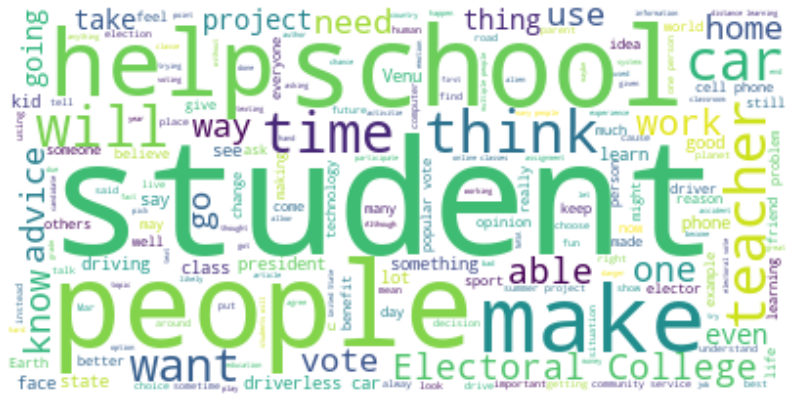

In [23]:
import matplotlib.pyplot as plt
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
train

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


<AxesSubplot:title={'center':'Number of Occurrences of each Discourse Type in All the Essays'}, ylabel='Type of Discourse'>

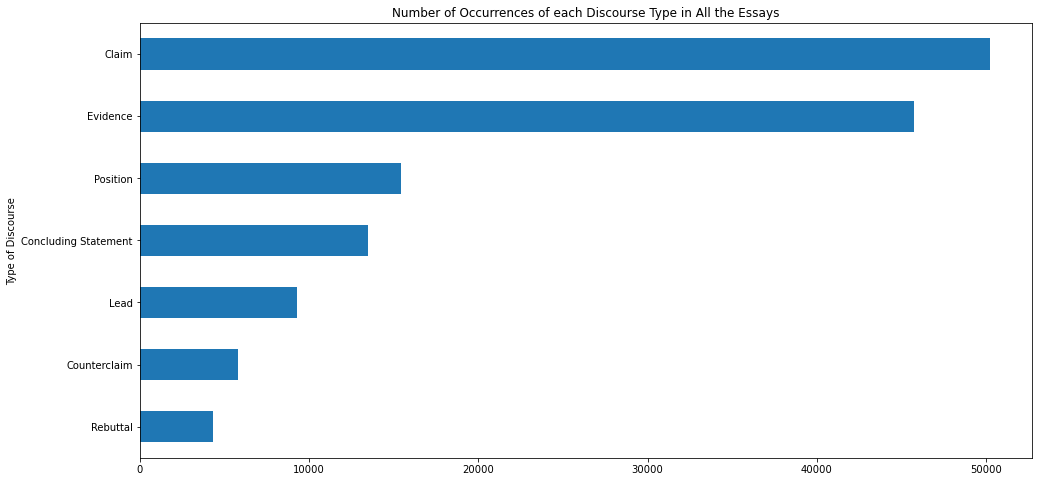

In [25]:
train.groupby("discourse_type").id.count().sort_values().plot.barh(figsize=(16,8), title="Number of Occurrences of each Discourse Type in All the Essays", xlabel="Type of Discourse")

In [26]:
train["prediction"] = train.predictionstring.str.split().apply(lambda lst:[int(i) for i in lst])
train["predictionLen"] = train["prediction"].apply(lambda lst:len(lst))

<AxesSubplot:title={'center':'Number of Words per Discourse Type in all of the Essays'}, ylabel='Type of Discourse'>

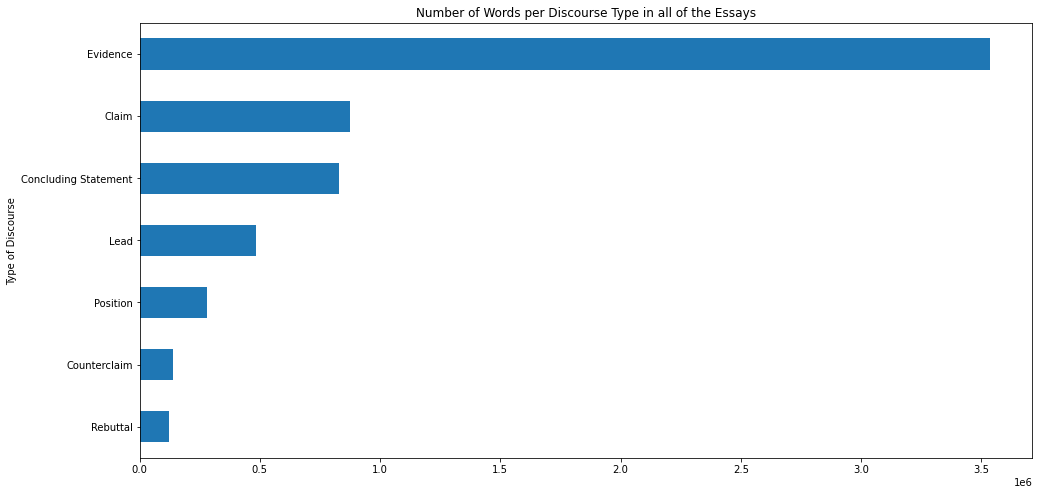

In [27]:
train.groupby("discourse_type").predictionLen.sum().sort_values().plot.barh(figsize=(16,8), title="Number of Words per Discourse Type in all of the Essays", xlabel="Type of Discourse")

In [28]:
with open("feedback-prize-2021/train/4C471936CD75.txt") as file:
    text = file.read()

print(text)

In ancient times, and also still today in some places, leaders of countries, such as presidents, prime ministers, kings, queens, and even the pharaohs of achient Egypt have all had advisers that they would consult to be sure they were making the best decision for their people. But these leaders would almost never have only one adviser, but more often than not they would have several in order to make sure they were doing what was right. But why would some of these leaders insist that they speak to multiple trusted advisers before they made any important decisions? I think someÂ of the reasons people, not solely world leaders, sometimes ask for advice from multiple trustworthy people before making a hard decision is because seeking multiple opinions can help you feel better about your decision to know that other people agree with you, and also because getting multiple opinions will increase the probability of one of those opinions being right.

I believe the main reason that people somet

In [29]:
# Process whole documents
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, "==>", entity.label_)

Noun phrases: ['ancient times', 'some places', 'leaders', 'countries', 'presidents', 'prime ministers', 'kings', 'queens', 'even the pharaohs', 'achient', 'Egypt', 'advisers', 'they', 'they', 'the best decision', 'their people', 'these leaders', 'only one adviser', 'they', 'order', 'they', 'what', 'some', 'these leaders', 'they', 'multiple trusted advisers', 'they', 'any important decisions', 'I', 'the reasons', 'people', 'world leaders', 'advice', 'multiple trustworthy people', 'a hard decision', 'multiple opinions', 'you', 'your decision', 'other people', 'you', 'multiple opinions', 'the probability', 'those opinions', 'I', 'the main reason', 'that', 'people', 'multiple peices', 'advice', 'hard decisions', 'you', 'your choice', 'more than one person', 'what', 'you', 'instance', 'the President', 'this', 'the best time', 'their country', 'war', 'they', 'the people', 'they', 'the government', 'the same way', 'it', 'the president', 'their decision', 'they', 'what', 'people', 'their decis

In [30]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

In in ADP IN prep Xx True True
ancient ancient ADJ JJ amod xxxx True False
times time NOUN NNS pobj xxxx True False
, , PUNCT , punct , False False
and and CCONJ CC cc xxx True True
also also ADV RB advmod xxxx True True
still still ADV RB conj xxxx True True
today today NOUN NN npadvmod xxxx True False
in in ADP IN prep xx True True
some some DET DT det xxxx True True
places place NOUN NNS pobj xxxx True False
, , PUNCT , punct , False False
leaders leader NOUN NNS nsubj xxxx True False
of of ADP IN prep xx True True
countries country NOUN NNS pobj xxxx True False
, , PUNCT , punct , False False
such such ADJ JJ amod xxxx True True
as as ADP IN prep xx True True
presidents president NOUN NNS pobj xxxx True False
, , PUNCT , punct , False False
prime prime ADJ JJ amod xxxx True False
ministers minister NOUN NNS conj xxxx True False
, , PUNCT , punct , False False
kings king NOUN NNS conj xxxx True False
, , PUNCT , punct , False False
queens queen NOUN NNS conj xxxx True False
, , PUNC

job job NOUN NN dobj xxx True False
running run VERB VBG acl xxxx True False
the the DET DT det xxx True True
country country NOUN NN dobj xxxx True False
because because SCONJ IN mark xxxx True True
they they PRON PRP nsubj xxxx True True
might might AUX MD aux xxxx True True
stress stress VERB VB advcl xxxx True False
about about ADP IN prep xxxx True True
it it PRON PRP pobj xx True True
. . PUNCT . punct . False False
But but CCONJ CC cc Xxx True True
if if SCONJ IN mark xx True True
they they PRON PRP nsubj xxxx True True
consulted consult VERB VBD advcl xxxx True False
many many ADJ JJ amod xxxx True True
advisers adviser NOUN NNS dobj xxxx True False
before before ADP IN prep xxxx True True
making make VERB VBG pcomp xxxx True False
that that DET DT det xxxx True True
vital vital ADJ JJ amod xxxx True False
decision decision NOUN NN dobj xxxx True False
, , PUNCT , punct , False False
the the DET DT det xxx True True
advisers adviser NOUN NNS nsubj xxxx True False
might might AU

In in ADP IN prep Xx True True
my my PRON PRP$ poss xx True True
experience experience NOUN NN pobj xxxx True False
, , PUNCT , punct , False False
seeking seek VERB VBG conj xxxx True False
multiple multiple ADJ JJ amod xxxx True False
opinions opinion NOUN NNS dobj xxxx True False
before before ADP IN prep xxxx True True
making make VERB VBG pcomp xxxx True False
a a DET DT det x True True
hard hard ADJ JJ amod xxxx True False
decision decision NOUN NN dobj xxxx True False
can can AUX MD aux xxx True True
be be AUX VB ROOT xx True True
beneficial beneficial ADJ JJ acomp xxxx True False
because because SCONJ IN prep xxxx True True
of of ADP IN pcomp xx True True
the the DET DT det xxx True True
reasons reason NOUN NNS pobj xxxx True False
stated state VERB VBN acl xxxx True False
above above ADV RB advmod xxxx True True
. . PUNCT . punct . False False
When when SCONJ WRB advmod Xxxx True True
I I PRON PRP nsubj X True True
was be AUX VBD advcl xxx True True
in in ADP IN prep xx True T

like like ADP IN prep xxxx True False
a a DET DT det x True True
third third ADJ JJ amod xxxx True True
grader grader NOUN NN nsubj xxxx True False
choosing choose VERB VBG pcomp xxxx True False
if if SCONJ IN mark xx True True
they they PRON PRP nsubj xxxx True True
want want VERB VBP advcl xxxx True False
to to PART TO aux xx True True
go go VERB VB xcomp xx True True
into into ADP IN prep xxxx True True
the the DET DT det xxx True True
advanced advanced ADJ JJ amod xxxx True False
program program NOUN NN pobj xxxx True False
in in ADP IN prep xx True True
school school NOUN NN pobj xxxx True False
, , PUNCT , punct , False False
but but CCONJ CC cc xxx True True
nonetheless nonetheless ADV RB advmod xxxx True False
, , PUNCT , punct , False False
asking ask VERB VBG csubj xxxx True False
for for ADP IN prep xxx True True
other other ADJ JJ amod xxxx True True
people people NOUN NNS poss xxxx True False
's 's PART POS case 'x False True
opinions opinion NOUN NNS pobj xxxx True False


      SPACE _SP dep    False False
Â â NOUN NN appos X True False
      SPACE _SP dep    False False
Â â NOUN NN appos X True False
    SPACE _SP dep   False False


In [31]:
displacy.render(doc, style="ent")

C:\Users\Prannaya\.conda\envs\analytics\lib\site-packages\spacy\displacy\__init__.py:65: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [32]:
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ORG"], "colors": colors}
displacy.render(doc, style="ent", options=options)

C:\Users\Prannaya\.conda\envs\analytics\lib\site-packages\spacy\displacy\__init__.py:65: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [33]:
assert doc.has_annotation("SENT_START")
for sent in doc.sents:
    print(sent.text)
    display(HTML("<hr>"))

In ancient times, and also still today in some places, leaders of countries, such as presidents, prime ministers, kings, queens, and even the pharaohs of achient Egypt have all had advisers that they would consult to be sure they were making the best decision for their people.


But these leaders would almost never have only one adviser, but more often than not they would have several in order to make sure they were doing what was right.


But why would some of these leaders insist that they speak to multiple trusted advisers before they made any important decisions?


I think someÂ of the reasons people, not solely world leaders, sometimes ask for advice from multiple trustworthy people before making a hard decision is because seeking multiple opinions can help you feel better about your decision to know that other people agree with you, and also because getting multiple opinions will increase the probability of one of those opinions being right.




I believe the main reason that people sometimes ask for multiple peices of advice before making hard decisions is because often makes you feel more confident in your choice to know more than one person believes what you are doing is right.


For instance, if the President thinks that this is the best time for their country to go to war, but they don't know if any of the people they rule over, or even the rest of the government, thinks the same way, it would almost certainly make the president feel less confident in their decision than if they knew what people thought about their decision, and they might not do as good a job running the country because they might stress about it.


But if they consulted many advisers before making that vital decision, the advisers might agree with the president, resulting in the president feeling more confident with their decision and ultimately leading the country better than if they just went with what one person said and didn't ask multiple people for advice first.




Another reason people might go to more than one person for advice before making a decision is because having more opinions increases the probability that one or more of the peopleÂ you go to for advice might have the right idea as to what you should do.


For example, if I'm not sure what college I want to attend, and I ask one friend where I should go, they might say "GeorgeÂ Mason" as a suggestion.


But if George Mason is not in fact the best college for me, even though the person I asked was trying to help, that one opinion could sway me to go there anyway and not have the best experience.


But yet if I go to ten people to advice, including the person who suggested George Mason, they might be the only one who would say that and maybe five of the other people I asked might say Virginia Tech, and I would decide to go to Virginia Tech instead of to GeorgeÂ Mason, and I would overall be happier and maybe even get better grades.


Then I would be more successful because I went to multiple people before I made a decision that could affect my entire life.


So therefore even though one person still has a chance to give valid advice, it is safer to talk to multiple people because it increases the chances of making a bad decision.




In my experience, seeking multiple opinions before making a hard decision can be beneficial because of the reasons stated above.


When I was in second grade, I passed the test to be admitted into the AAP (Advanced Academics Program) in my school.


My best friend was also accepted, and wanted me to go to AAP with her, but I didnt really want to go into AAP.


I told my parents this, and they agreed it would be best for me to stay in the normal class for on more year.


Since I got my parents' opinions, I also felt more secure staying out of the advanced program even though my friend wanted me to do the opposite and go into the program.


And so in third grade, I was not in AAP with my best friend, but nonetheless, I was happy and met many new friends in the normal class, some of whom are still my friends today.


When I went into fourth grade, however, I decided that I wanted to go into the AAP program.


Since I had already gotten in a yearÂ before, I was not required to retake the test and went in smoothly to the advanced program.


In this example, I sought three opinions (my parents and my best friend) in order to make a decision,Â but if I had taken my friend's advice alone, I would have gone into AAP in third grade and not have been as happy as I was in the regular class.


Â This shows clearly that it is better to seekÂ multiple opinions instead of just one.


The impact of asking people to helpÂ you make a decision can be big, like a country deciding to go to war, or small, like a third grader choosing if they want to go into the advanced program in school, but nonetheless, asking for other people's opinions instead of just one person's opinion can make a difference in someone's life, whether big or small.




Of course, there are many other reasons one might want to seek multiple opinions and pieces of advice instead of just one, but these are the two main ones that I think really make it worthwhile to ask for advice from multiple people instead of making decisions with only one piece of advice from one person.


The key thing that all of these examples have shown is that it is better to seek multiple opinions from multiple different people than to only get advice from one.


This is ultimately because asking multiple people for advice makes you feel better about the decisions you make and also increases the chances that one or more of the people you consulted with gave you the right advice at the right time to empower you do what is right for you (or perhaps what is right for the country you happen to be in charge of!).Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â 


In [34]:
nlp.enable_pipe("senter")
doc2 = nlp(text)
for sent in doc2.sents:
    print(sent.text)
    display(HTML("<hr>"))

In ancient times, and also still today in some places, leaders of countries, such as presidents, prime ministers, kings, queens, and even the pharaohs of achient Egypt have all had advisers that they would consult to be sure they were making the best decision for their people.


But these leaders would almost never have only one adviser, but more often than not they would have several in order to make sure they were doing what was right.


But why would some of these leaders insist that they speak to multiple trusted advisers before they made any important decisions?


I think someÂ of the reasons people, not solely world leaders, sometimes ask for advice from multiple trustworthy people before making a hard decision is because seeking multiple opinions can help you feel better about your decision to know that other people agree with you, and also because getting multiple opinions will increase the probability of one of those opinions being right.




I believe the main reason that people sometimes ask for multiple peices of advice before making hard decisions is because often makes you feel more confident in your choice to know more than one person believes what you are doing is right.


For instance, if the President thinks that this is the best time for their country to go to war, but they don't know if any of the people they rule over, or even the rest of the government, thinks the same way, it would almost certainly make the president feel less confident in their decision than if they knew what people thought about their decision, and they might not do as good a job running the country because they might stress about it.


But if they consulted many advisers before making that vital decision, the advisers might agree with the president, resulting in the president feeling more confident with their decision and ultimately leading the country better than if they just went with what one person said and didn't ask multiple people for advice first.




Another reason people might go to more than one person for advice before making a decision is because having more opinions increases the probability that one or more of the peopleÂ you go to for advice might have the right idea as to what you should do.


For example, if I'm not sure what college I want to attend, and I ask one friend where I should go, they might say "GeorgeÂ Mason" as a suggestion.


But if George Mason is not in fact the best college for me, even though the person I asked was trying to help, that one opinion could sway me to go there anyway and not have the best experience.


But yet if I go to ten people to advice, including the person who suggested George Mason, they might be the only one who would say that and maybe five of the other people I asked might say Virginia Tech, and I would decide to go to Virginia Tech instead of to GeorgeÂ Mason, and I would overall be happier and maybe even get better grades.


Then I would be more successful because I went to multiple people before I made a decision that could affect my entire life.


So therefore even though one person still has a chance to give valid advice, it is safer to talk to multiple people because it increases the chances of making a bad decision.




In my experience, seeking multiple opinions before making a hard decision can be beneficial because of the reasons stated above.


When I was in second grade, I passed the test to be admitted into the AAP (Advanced Academics Program) in my school.


My best friend was also accepted, and wanted me to go to AAP with her, but I didnt really want to go into AAP.


I told my parents this, and they agreed it would be best for me to stay in the normal class for on more year.


Since I got my parents' opinions, I also felt more secure staying out of the advanced program even though my friend wanted me to do the opposite and go into the program.


And so in third grade, I was not in AAP with my best friend, but nonetheless, I was happy and met many new friends in the normal class, some of whom are still my friends today.


When I went into fourth grade, however, I decided that I wanted to go into the AAP program.


Since I had already gotten in a yearÂ before, I was not required to retake the test and went in smoothly to the advanced program.


In this example, I sought three opinions (my parents and my best friend) in order to make a decision,Â but if I had taken my friend's advice alone, I would have gone into AAP in third grade and not have been as happy as I was in the regular class.


Â This shows clearly that it is better to seekÂ multiple opinions instead of just one.


The impact of asking people to helpÂ you make a decision can be big, like a country deciding to go to war, or small, like a third grader choosing if they want to go into the advanced program in school, but nonetheless, asking for other people's opinions instead of just one person's opinion can make a difference in someone's life, whether big or small.




Of course, there are many other reasons one might want to seek multiple opinions and pieces of advice instead of just one, but these are the two main ones that I think really make it worthwhile to ask for advice from multiple people instead of making decisions with only one piece of advice from one person.


The key thing that all of these examples have shown is that it is better to seek multiple opinions from multiple different people than to only get advice from one.


This is ultimately because asking multiple people for advice makes you feel better about the decisions you make and also increases the chances that one or more of the people you consulted with gave you the right advice at the right time to empower you do what is right for you (or perhaps what is right for the country you happen to be in charge of!).Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â 


In [35]:
nlp2 = English()  # just the language with no pipeline
nlp2.add_pipe("sentencizer")
doc3 = nlp2(text)
for sent in doc3.sents:
    print(sent.text)
    display(HTML("<hr>"))

In ancient times, and also still today in some places, leaders of countries, such as presidents, prime ministers, kings, queens, and even the pharaohs of achient Egypt have all had advisers that they would consult to be sure they were making the best decision for their people.


But these leaders would almost never have only one adviser, but more often than not they would have several in order to make sure they were doing what was right.


But why would some of these leaders insist that they speak to multiple trusted advisers before they made any important decisions?


I think someÂ of the reasons people, not solely world leaders, sometimes ask for advice from multiple trustworthy people before making a hard decision is because seeking multiple opinions can help you feel better about your decision to know that other people agree with you, and also because getting multiple opinions will increase the probability of one of those opinions being right.




I believe the main reason that people sometimes ask for multiple peices of advice before making hard decisions is because often makes you feel more confident in your choice to know more than one person believes what you are doing is right.


For instance, if the President thinks that this is the best time for their country to go to war, but they don't know if any of the people they rule over, or even the rest of the government, thinks the same way, it would almost certainly make the president feel less confident in their decision than if they knew what people thought about their decision, and they might not do as good a job running the country because they might stress about it.


But if they consulted many advisers before making that vital decision, the advisers might agree with the president, resulting in the president feeling more confident with their decision and ultimately leading the country better than if they just went with what one person said and didn't ask multiple people for advice first.




Another reason people might go to more than one person for advice before making a decision is because having more opinions increases the probability that one or more of the peopleÂ you go to for advice might have the right idea as to what you should do.


For example, if I'm not sure what college I want to attend, and I ask one friend where I should go, they might say "GeorgeÂ Mason" as a suggestion.


But if George Mason is not in fact the best college for me, even though the person I asked was trying to help, that one opinion could sway me to go there anyway and not have the best experience.


But yet if I go to ten people to advice, including the person who suggested George Mason, they might be the only one who would say that and maybe five of the other people I asked might say Virginia Tech, and I would decide to go to Virginia Tech instead of to GeorgeÂ Mason, and I would overall be happier and maybe even get better grades.


Then I would be more successful because I went to multiple people before I made a decision that could affect my entire life.


So therefore even though one person still has a chance to give valid advice, it is safer to talk to multiple people because it increases the chances of making a bad decision.




In my experience, seeking multiple opinions before making a hard decision can be beneficial because of the reasons stated above.


When I was in second grade, I passed the test to be admitted into the AAP (Advanced Academics Program) in my school.


My best friend was also accepted, and wanted me to go to AAP with her, but I didnt really want to go into AAP.


I told my parents this, and they agreed it would be best for me to stay in the normal class for on more year.


Since I got my parents' opinions, I also felt more secure staying out of the advanced program even though my friend wanted me to do the opposite and go into the program.


And so in third grade, I was not in AAP with my best friend, but nonetheless, I was happy and met many new friends in the normal class, some of whom are still my friends today.


When I went into fourth grade, however, I decided that I wanted to go into the AAP program.


Since I had already gotten in a yearÂ before, I was not required to retake the test and went in smoothly to the advanced program.


In this example, I sought three opinions (my parents and my best friend) in order to make a decision,Â but if I had taken my friend's advice alone, I would have gone into AAP in third grade and not have been as happy as I was in the regular class.


Â This shows clearly that it is better to seekÂ multiple opinions instead of just one.


The impact of asking people to helpÂ you make a decision can be big, like a country deciding to go to war, or small, like a third grader choosing if they want to go into the advanced program in school, but nonetheless, asking for other people's opinions instead of just one person's opinion can make a difference in someone's life, whether big or small.




Of course, there are many other reasons one might want to seek multiple opinions and pieces of advice instead of just one, but these are the two main ones that I think really make it worthwhile to ask for advice from multiple people instead of making decisions with only one piece of advice from one person.


The key thing that all of these examples have shown is that it is better to seek multiple opinions from multiple different people than to only get advice from one.


This is ultimately because asking multiple people for advice makes you feel better about the decisions you make and also increases the chances that one or more of the people you consulted with gave you the right advice at the right time to empower you do what is right for you (or perhaps what is right for the country you happen to be in charge of!).Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â 


In [36]:
processed = train.discourse_text.map(lambda x: re.sub('[,\.!?]', '', x).lower())
processed

<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
C:\Users\Prannaya\AppData\Local\Temp/ipykernel_19476/4006046965.py:1: DeprecationWarning: invalid escape sequence \.
  processed = train.discourse_text.map(lambda x: re.sub('[,\.!?]', '', x).lower())


0         modern humans today are always on their phone ...
1         they are some really bad consequences when stu...
2         some certain areas in the united states ban ph...
3         when people have phones they know about certai...
4         driving is one of the way how to get around pe...
                                ...                        
144288     if i'm not sure what college i want to attend...
144289     seeking multiple opinions before making a har...
144290    it is better to seek multiple opinions instead...
144291    the impact of asking people to help you make a...
144292    there are many other reasons one might want to...
Name: discourse_text, Length: 144293, dtype: object

In [37]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['modern', 'humans', 'today', 'always', 'phone', 'always', 'phone', 'hours', 'day', 'stop', 'text', 'back', 'forward', 'group', 'chats', 'social', 'media', 'even', 'driving']


In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)]


In [39]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"students" + 0.013*"would" + 0.013*"people" + 0.011*"think" + '
  '0.011*"time" + 0.011*"school" + 0.010*"could" + 0.009*"help" + 0.008*"many" '
  '+ 0.007*"work"'),
 (1,
  '0.015*"people" + 0.014*"cars" + 0.011*"driving" + 0.010*"car" + 0.009*"day" '
  '+ 0.008*"could" + 0.008*"phones" + 0.007*"many" + 0.006*"also" + '
  '0.005*"way"'),
 (2,
  '0.026*"venus" + 0.010*"author" + 0.010*"cars" + 0.008*"people" + '
  '0.008*"would" + 0.008*"earth" + 0.007*"planet" + 0.006*"many" + '
  '0.006*"world" + 0.006*"system"'),
 (3,
  '0.031*"people" + 0.026*"advice" + 0.021*"person" + 0.020*"one" + '
  '0.020*"ask" + 0.015*"make" + 0.013*"get" + 0.013*"know" + 0.013*"help" + '
  '0.013*"opinions"'),
 (4,
  '0.025*"school" + 0.021*"students" + 0.017*"would" + 0.014*"home" + '
  '0.010*"also" + 0.009*"people" + 0.009*"classes" + 0.009*"get" + '
  '0.008*"work" + 0.007*"make"'),
 (5,
  '0.030*"students" + 0.023*"would" + 0.015*"vote" + 0.014*"school" + '
  '0.012*"get" + 0.011*"college"

In [40]:
# Visualize the topics
!mkdir results
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

A subdirectory or file results already exists.
C:\Users\Prannaya\.conda\envs\analytics\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.088653  0.065795       1        1  21.217949
3     -0.154646 -0.050157       2        1  14.165312
8      0.063989 -0.070829       3        1  11.303752
7     -0.026411 -0.049854       4        1  10.807491
0     -0.013284  0.016648       5        1   9.524330
9     -0.029423  0.022775       6        1   7.802701
4      0.013348  0.037188       7        1   7.701886
2      0.087051 -0.017733       8        1   6.676273
6      0.072467  0.083331       9        1   6.128820
1      0.075562 -0.037165      10        1   4.671487, topic_info=           Term          Freq         Total Category  logprob  loglift
950      school  28653.000000  28653.000000  Default  30.0000  30.0000
9084      venus  11423.000000  11423.000000  Default  29.0000  29.0000
136         car  24284.000000  24284.000000  Default  28.0000  28.0000
2464     advice  20061.000000  20061.000000  Default  27.0000  27.0000
937    students  42840.000000  42840.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
166        work    515.689686  12793.799503  Topic10  -5.6168  -0.1475
937    students    658.764408  42840.687221  Topic10  -5.3719  -1.1112
3878  president    460.525429   8607.191506  Topic10  -5.7299   0.1357
43         like    492.463845  18916.649177  Topic10  -5.6628  -0.5847
472       world    415.901146   6666.262991  Topic10  -5.8318   0.2893

[904 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
121        1  0.333680    able
121        2  0.062064    able
121        3  0.060423    able
121        4  0.083878    able
121        5  0.137642    able
...      ...       ...     ...
528        7  0.185689    year
528        8  0.045361    year
528        9  0.093375    year
528       10  0.088335    year
20339      4  0.938824  yelled

[3324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 9, 8, 1, 10, 5, 3, 7, 2])

In [41]:
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.017*"students" + 0.013*"would" + 0.013*"people" + 0.011*"think"')
(1, '0.015*"people" + 0.014*"cars" + 0.011*"driving" + 0.010*"car"')
(2, '0.026*"venus" + 0.010*"author" + 0.010*"cars" + 0.008*"people"')
(3, '0.031*"people" + 0.026*"advice" + 0.021*"person" + 0.020*"one"')
(4, '0.025*"school" + 0.021*"students" + 0.017*"would" + 0.014*"home"')
(5, '0.030*"students" + 0.023*"would" + 0.015*"vote" + 0.014*"school"')
(6, '0.025*"students" + 0.017*"venus" + 0.013*"learning" + 0.012*"distance"')
(7, '0.032*"people" + 0.019*"driverless" + 0.014*"cars" + 0.012*"would"')
(8, '0.039*"car" + 0.025*"people" + 0.022*"cars" + 0.017*"driving"')
(9, '0.031*"school" + 0.016*"students" + 0.016*"time" + 0.014*"phones"')


In [42]:
train

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,prediction,predictionLen
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",44
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,"[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5...",15
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...",16
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...",63
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,"[139, 140, 141, 142, 143, 144, 145, 146, 147, ...",24
...,...,...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...,"[386, 387, 388, 389, 390, 391, 392, 393, 394, ...",187
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...,"[576, 577, 578, 579, 580, 581, 582, 583, 584, ...",252
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838,"[828, 829, 830, 831, 832, 833, 834, 835, 836, ...",11
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...,"[839, 840, 841, 842, 843, 844, 845, 846, 847, ...",64


In [43]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

ARTICLE_TO_SUMMARIZE = train.discourse_text[0]
inputs = tokenizer(ARTICLE_TO_SUMMARIZE, max_length=1024, return_tensors="pt")

# Generate Summary
summary_ids = model.generate(inputs["input_ids"])
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
#"California's largest electricity provider has turned off power to hundreds of thousands of customers."

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


'How much time do you spend on your phone?'

In [4]:
print(train.discourse_text[0])

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.


In [15]:
print(" ".join(train.query("id == '4C471936CD75'").discourse_text.str.strip()).replace("\n", ""))

In ancient times, and also still today in some places, leaders of countries, such as presidents, prime ministers, kings, queens, and even the pharaohs of achient Egypt have all had advisers that they would consult to be sure they were making the best decision for their people. But these leaders would almost never have only one adviser, but more often than not they would have several in order to make sure they were doing what was right. But why would some of these leaders insist that they speak to multiple trusted advisers before they made any important decisions? seeking multiple opinions can help you feel better about your decision to know that other people agree with you, getting multiple opinions will increase the probability of one of those opinions being right. if the President thinks that this is the best time for their country to go to war, but they don't know if any of the people they rule over, or even the rest of the government, thinks the same way, it would almost certainly 

In [20]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

text = " ".join(train.query("id == '4C471936CD75'").discourse_text.str.strip()).replace("\n", "")

inputs = tokenizer(text, max_length=512, truncation=True, return_tensors="pt")

# Generate Summary
summary_ids = model.generate(inputs["input_ids"])
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

'If you want to make the best decision for yourself, or for the country, you might want to seek multiple opinions before you make a decision.'

In [22]:
def summariseText(text):
    inputs = tokenizer(text, max_length=512, truncation=True, return_tensors="pt")

    # Generate Summary
    summary_ids = model.generate(inputs["input_ids"])
    return tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [23]:
train.tail(20)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
144273,AFEC37C2D43F,1.617803e+12,693.0,710.0,"misunderstanding,",Claim,Claim 2,121
144274,AFEC37C2D43F,1.617803e+12,714.0,724.0,misdeed.,Claim,Claim 3,123
144275,AFEC37C2D43F,1.617803e+12,725.0,1360.0,While mistakes and misunderstanding might have...,Evidence,Evidence 1,124 125 126 127 128 129 130 131 132 133 134 13...
144276,AFEC37C2D43F,1.617803e+12,1361.0,1471.0,"The more similar iterations people give you, t...",Claim,Claim 4,234 235 236 237 238 239 240 241 242 243 244 24...
144277,AFEC37C2D43F,1.617803e+12,1472.0,1881.0,Misunderstandings are harder to avoid because ...,Evidence,Evidence 2,252 253 254 255 256 257 258 259 260 261 262 26...
144278,AFEC37C2D43F,1.617803e+12,1882.0,2019.0,The best thing to do in a situation like that ...,Claim,Claim 5,326 327 328 329 330 331 332 333 334 335 336 33...
144279,AFEC37C2D43F,1.617803e+12,2029.0,2123.0,misdeeds are when the advice-giver is purpose...,Claim,Claim 6,354 355 356 357 358 359 360 361 362 363 364 36...
144280,AFEC37C2D43F,1.617803e+12,2123.0,2702.0,An example of this is when you ask Generic_Nam...,Evidence,Evidence 3,368 369 370 371 372 373 374 375 376 377 378 37...
144281,AFEC37C2D43F,1.617803e+12,2703.0,2799.0,"Now, I know what you probably saying ""But what...",Counterclaim,Counterclaim 1,465 466 467 468 469 470 471 472 473 474 475 47...
144282,AFEC37C2D43F,1.617803e+12,2817.0,2907.0,what are the odds that seven of your close fr...,Rebuttal,Rebuttal 1,487 488 489 490 491 492 493 494 495 496 497 49...


In [25]:
with open("feedback-prize-2021/train/AFEC37C2D43F.txt") as f:
    text = f.read()

summariseText(text)

'In our series of letters from African-American journalists, film-maker, and columnist Fawaz Al Hasawi looks at three different types of advice-giving.'

In [ ]:
titles = {}
for id in train.id.unique():
    with open(f"feedback-prize-2021/train/{id}.txt") as f:
        text = f.read()
    title = summariseText(text)
    print(id, " -> ", title)
    titles[id] = [text, title]

423A1CA112E2  ->  Here's what you need to know about mobile phones.
A8445CABFECE  ->  Drivers should not be able to use their phones while driving, according to the National Highway Traffic Safety Administration (NHTSA).
6B4F7A0165B9  ->  The use of a cell phone while driving is not a new invention.
E05C7F5C1156  ->  The use of a cell phone while operating a vehicle has become a hot topic. I also think that you shouldn't use your phone while operating a vehicle because it can cause vehicle collisions, slow reaction time, and fatal injuries.
50B3435E475B  ->  In my opinion texting and driving is dangerous and should be banned.
DBF7EB6A9E02  ->  Drivers should not be able to use cell phones in any capacity while operating a motor vehicle.
810B70E80E1D  ->  Drivers shouldn't drive while using a phone because if more people don't drive with their phones the likelihood of them getting into a possibly fatal accident decrease by a lot, there are also ways that you phone can keep itself from b

9F5A37599E7B  ->  What do you think should be done to stop drivers from texting and driving?
40CC76613B2D  ->  There is no such thing as a safe time to use a mobile device while driving.
4000B8222A07  ->  More and more people are using their mobile phones while driving.
2022539CFE3E  ->  Do you use your cell phone while you're driving? So not only are you multitasking and not focusing your eyes from the road, but you're also trying to deftly use your phone with one hand while at the same time steer your vehicle.
15128715053E  ->  This week I want to talk about using a cell phone while driving. "Texting while driving is six times more likely to cause an accident than driving drunk." (Edwards 1) If you even use a simple text it can take your eyes off the road for a few seconds.
E3830AB95CD7  ->  Car gadgets can help prevent accidents and accidents in general.
E92185894096  ->  What do you think should be done to stop people from texting while driving?
9B45D0A9E4C0  ->  A lot of people ar

6DE03443CD95  ->  Texting and driving has become a big problem in today's world.
C2135455106D  ->  This week i'm going to be talking about the dangers of phones and driving.
D0B25FD48780  ->  Many people have died from car accidents because of people using their phone while driving.
E7C2FE6B860D  ->  It's that time of year again when people are rushing to get to work, school, or anything else at some point in their lives.
42BCE55192A0  ->  Drivers should not be able to use cell phones in any capacity while operating a vehicle.
F92664C55FBB  ->  In 2018 deaths related to cell phone use in cars accidents was 4,637 in the U.S alone.
6CD55BD836C3  ->  Texting while driving is a big issue and we doing it every day and not realizing how much we are putting our lives in a danger and putting the others people who on the road lives in dangerous.
F91704A35E31  ->  People often use their phones while they're driving. Most people often use their phones while driving because they feel capable of do

2FB13DEA0047  ->  Drivers should not be allowed to use their cell phones when in use of a vehicle because it increases the chance for an accident and decreases focus during the ride.
72E99FD177CC  ->  How should people be allowed to use their phones while driving? Phones & Driving Should people be able to use their phones in any capacity while driving?
6C8D8C5145DB  ->  People who use their cell phones while driving put their lives in serious danger.
A6527612255D  ->  On the day of July 1, 2018 a new law saying that " Drivers cannot have a phone in their HAND or touching any part of their body while talking on their phone while driving".
7EA3E3CAB822  ->  The usage of cell phones while operating a vehicle is a very debatable topic.
2513771E4659  ->  The number of people killed in car accidents in the United States is on the rise and according to the National Highway Traffic Safety Administration (NHTSA) the number of people killed in car accidents is on the rise and according to the Na

C3422BCCE00F  ->  There are many ways to prevent texting and driving and one of them is simply putting your device down and not using it when behind the wheel.
9B21F354EAE6  ->  A lot of people use their cell phones while driving.
6FCAA7BE2809  ->  Do you use a cell phone while driving?
08365867DCBE  ->  Texting and driving has become a big problem on our roads and highways.
BB6793327D1C  ->  Cell phones have come a long way in the last few years.
4BC206F5ECB2  ->  There are many reasons why drivers should not be able to use their cell phones while driving.
3FCC179594CD  ->  Driving is one of the most dangerous things you can do while on the road.
D03194D9A636  ->  Driving while using a cellular device is very dangerous, but it can be useful at certain times.
1B4AFEB6E86E  ->  On the morning of the 30th of March 2013, a Texas church bus was hit by a pickup truck that was texting and driving.
A075A1335A25  ->  People who use cell phones while driving are putting their lives at risk.
5DB

4A4E55ACDEC7  ->  Why is texting and driving dangerous?
D7946F0C2A83  ->  Using your phone while driving is not a good idea.
34969C5FF82C  ->  Texting and driving can be dangerous and should not be allowed in this time in age or in the future.
A6C2B78B2EE9  ->  Is it time to stop using your phone while driving?
309272016742  ->  In our series of letters from African journalists, filmmaker and columnist Farai Sevenzo looks at the dangers of using a phone while driving.
A010A4C2C9D2  ->  Drivers Should Not Be Able To Use Cell Phone In Any Capacity While Operating A Vehicle How many of you have been in a car accident?
034A48259522  ->  Texting and driving should be banned in all 50 states.
E07EA4606938  ->  Cell phones and driving is a serious thing Nowdays cause one minute your alive and then next minute your dead all because of your cell phone people please put down the cell phones when you're driving or put it on the phone stand in your car or just keep it in your pocket untill you get

4D30DAAE61A0  ->  Driving is a privilege and it matters more and more every year as more people get distracted by the newest feature on their phone. Driving is a privilege has always been true but it matters more and more every year as more people get distracted by the newest feature on their phone.
9DBB8B0C3367  ->  Texting while driving is as dangerous as driving drunk.
681F17F5EAA5  ->  It is very tempting to use your phone while operating a vehicle.
638D16E51763  ->  Driving Essay Driving has become an everyday thing to citizens.
857F67692BC4  ->  Texting while driving should be illegal, as far as death and prison time, according to the National Safety Council. Texting while driving should be illegal "The National Safety Council reports that cell phone use while driving leads to 1.6 million crashes each year.
6FF14DD83450  ->  Do you use your phone while driving or texting while driving?
255D6971699A  ->  Texting while driving can cause you to get into an accident, it can cause you

9664FB49D053  ->  How do you feel about using a phone while driving?
504FFF4C522D  ->  According to the National Highway Traffic Safety Administration texting and driving is the leading cause of traffic accidents in the United States.
3A46013B0369  ->  How dangerous is it to drive while using a mobile phone?
D4108B56F2DF  ->  Driving with a device in hand can lead to death or injury to thousands of other people.
8D455E3C33BF  ->  Technology has always been an important part of our lives.
A88767C338D3  ->  The dangers of texting and driving are well known.
BB2E4FA20755  ->  Texting while driving is one of the biggest problems in the world.
0CF271851342  ->  Cell phones should not be used while driving because you are more than likely at risk of having a wreck.
CB7C7ED5174A  ->  Using a phone while driving is dangerous to the driver themselves as well as the safety of others because we can't put down our phones.
C23CF8BE0937  ->  Drivers should be allowed to use their mobile phones while

3453B0EC32D3  ->  As a society, we have become so focused on how much we can do at one time that we are willing to risk our personal safety as well as the safety of others because we can't put down our cell phones. As a society, we have become so focused on how much we can do at one
53B50E488C81  ->  In our series of letters from African journalists, film-maker and columnist Farai Sevenzo looks at the issue of drivers using their phones while driving.
2F159741CBBE  ->  The National Highway Traffic Safety Administration (NHTSA) recommends that drivers refrain from using their mobile phones while driving.
6D413198B41F  ->  If you've ever been in a car accident, you'll know how dangerous texting and driving can be.
AA04D8A7A312  ->  Texting and driving is a huge problem.
29067E722A0A  ->  As more and more people use their mobile phones while driving, the number of accidents on highways and freeways is on the rise as a direct result of people using their phones while operating motored vehi

7B1B9534D51A  ->  Do not be on your phone while driving, it is never worth the risk of getting hurt.
B5DE2FAE1DB5  ->  Texting and driving has got to the point where the government has taken major action into making it illegal.
CFF21231DFEC  ->  Do you think drivers should be able to use their cellphones in any capacity while operating a vehicle?
0A7B1C9CEF07  ->  The use of cell phones while driving has become a major cause of road accidents.
E798ED577B8B  ->  Cell phones should not be used while driving because it poses a serious threat to the safety of other drivers and their passengers.
02BC8A1B2D2F  ->  Drivers should not be able to use cell phones in any capacity while operating a vehicle due to the risk of damage, injury, and death that they not only put onto themselves, but others and society as a whole.
28F610F27D8E  ->  There are a lot of people using their cell phones while they're driving.
EB763115B6CD  ->  According to the National Highway Traffic Safety Administration (NH

13D15CC5EB78  ->  In the US, the government has recently been putting laws on phones being used while driving.
CA0BE26915AE  ->  Using a cell phone while driving is one of the most dangerous things that you can do on the road.
482DB8018CBA  ->  Using your phone while driving may be beneficial but remember your safety comes first.
90BC4A0EDED0  ->  Cell phones have become so much of a distraction to the point where people are immune to picking up their phone every time they receive a notification.
2DDF8DD0BE20  ->  Driving while using a cell phone is not worth the consequences.
BEE3471F7F15  ->  If you have ever been involved in a car accident then you know the dangers of distracted driving.
8F625951F759  ->  What do you think should be done about texting while driving?
7283BE179AED  ->  Cellphones have become a major issue in the field of driving.
DC76E46519A7  ->  Do you think drivers should be banned from using their phones while driving? Phones & Driving Well to begin with, I think 

4B96AA0C1382  ->  Driving while using a handheld mobile phone is illegal in all 50 states and the District of Columbia.
6C633E9AAFC3  ->  Have you ever been caught using your phone while driving?
E292C956B6B7  ->  It's never ok to be on your phone while driving.
95BC127CB3A2  ->  Have you ever thought what it would be like not having to pay for gas everyday?
DB781EC6153A  ->  One of our leading problems of polution is our cars.
DCDBC5C7873F  ->  Limiting car usages has positive effect on our environment by reducing smog, the decrease in traffic jams, and also improves our safety. The limiting of our car usages has positive effect on our enviroment by the reducing of smog, the decrease in traffic jams, conserves our resources and time, and also improves our
0B606C33AC4D  ->  What are the benefits of getting rid of cars?
D73D85780CE1  ->  How would you feel if your city banned driving cars for a day or two?
537F0D35DB52  ->  It is a good idea to limit the usage of gas transportation.
53A

E570BB4A5B5B  ->  Is America passing peak drving?
4CC1CE8BBE25  ->  The world is trying to rid itself of cars.
7A1940992606  ->  In our series of letters from African journalists, filmmaker and columnist Ahmedou Ould-Abdallah looks at the advantages of limiting car use.
2A6678ABADEB  ->  One of the main causes of pollution is the use of cars.
68FB76B3413E  ->  In our series of letters from African-Americans, writer and novelist Heidrun Walter looks at the advantages of limiting car usage.
5E3A5B645F49  ->  In source 2 the autor talks about one of the biggest advantages of limiting car usage, by cleaning the air of pollution.
505E8295E792  ->  If you want to know what is going on in the world of cars you might want to read this article by Elisabeth Rosenthal.
0CF1CB5E06EE  ->  A car-free day is a day when a city restricts the use of cars.
412F965FE701  ->  The French newspaper Le Parisien has a very interesting article about limiting car usage.
D930E883CCBC  ->  It's my first day of dri

89250C89D474  ->  What do you think should be done to reduce the number of cars on the roads?
7A143C2BC7F9  ->  I've been reading a lot of articles about limiting car usage.
2C27E003116B  ->  When we think of cars and the environment, we usually think of pollution and congestion.
F24192427334  ->  The environment is doing beter without vehicles and we need to clear up the air of the global city.
0C952AD5C1EA  ->  In Germany, there is a new district that has forbidden parking, driveways, garages, and the residents of this upscale community are poineers.
5208ECB70235  ->  Source1: "The end of car culture"
58C092C01C79  ->  It's better for citizens to have a car to run erences and do what they got to do to get some where.
04AA83899997  ->  There are so many advantages of not driving cars as much or at all, it would really help protect the worlds air, and could be a great source of exercise!
72F756E359DE  ->  People are no longer using their cars as a form of transportation in many cities 

DC22349FF001  ->  In our series of letters from African journalists, filmmaker and media trainer Heidrun Walter looks at the benefits of limiting car usage.
1909DEE8C6B8  ->  Cars are going to be gone in the near future.
4384C3FCDF24  ->  There are many ways people may be harming the environment without actually knowing it.
18D68AEC46D6  ->  Some states in the United States are limiting the amount of time people can use their cars.
A32384C84D4A  ->  Automobiles have changed our lives for the better and for the worse.
D9376FA15233  ->  There are many efforts from different countries to reduce car usage.
88553C663AF4  ->  People are giving up their cars because of reasons such as, street parking, driveways, and home garages are forbidden in places where their reason for it is so they can experiment the outcome of it for a more secure data.
76376E98F6EF  ->  In a recent article in the New York Times, author and journalist, Jodi Rosenthal, describes the city of New York as a car-less city.

8D41F946EB16  ->  Is it really good to have a car-free suburb?
B867F487B9F3  ->  The Lively Impacts from a Dead Engine Personal automobiles and cars have played a major role throughout the world since the invention of the car in World War 2. The Lively Impacts from a Dead Engine Personal automobiles and cars have played a major role throughout the world since the invention of the car in World War 2.
FD5347E3C97B  ->  The days of owning a car seem to be over. In the Untied States less people are starting to use cars, not because they will be fined but because a change in culture.
94A8B4DE1712  ->  The mayor of Bogota in Colombia has ordered all cars off the road for a day in an attempt to reduce air pollution.
DF82C12CD27F  ->  In case you missed it, here's a round-up of some of the top news stories of the week:
E8E5F696B50D  ->  There are many people around the world that do not drive a car.
3FCA40583533  ->  Becoming car-free has many advantages.
001552828BD0  ->  What would you do to

3C51D74AB756  ->  Limiting car usage is beneficial for the environment and the community as a whole.
D6F39AE89719  ->  If the world was without cars, what would it be like?
20F22FC302C4  ->  There are many advantages to limiting car usage.
FFBA3014CDC7  ->  How do you get to where you need to go?
F468E21A6DEE  ->  Car-free days are all the rage right now.
E6E39EFC638C  ->  Life goes on without the use of a machine.
DA9728426CA5  ->  In our series of letters from African journalists, filmmaker and columnist Farai Sevenzo looks at the benefits of limiting car usage.
FF71B53EC31F  ->  There are many benefits to not driving and not owning a car.
8ABA260B3B98  ->  Many countries are trying to cut down on the amount of greenhouse gasses that are polluting the earth.
0586962EE9E8  ->  The car has been a huge part of our lives for thousands of years.
CC82A1D80D1A  ->  A small experimental suburb in Germany is tooling with the idea of a no car life style, along with many cities in the United St

D2BB8E9332D1  ->  There's a revolution that stands before us in the form of a new lifestyle: Car-free living.
D698ED5E6B70  ->  A new trend is starting to spread rapidly across America and all over Europe.
8FFBD4C432B4  ->  In our series of letters from African journalists, filmmaker and columnist Farai Sevenzo looks at ways to reduce the use of cars.
DC02852088A0  ->  Is it really possible to live without cars?
DBBEA6856321  ->  Cities around the world are trying to reduce the amount of cars on the roads.
122624B918CD  ->  In our series of letters from African journalists, film-maker, and columnist Ahmed Rashid looks at why we should consider reducing car usage.
BE1F20C5B099  ->  The advantages of limiting car usage is that it helps the envirornment to stay healthy, it helps bring the rate of high car usage down and lets people take bikes, skates, and ect.
A51FCD8809EA  ->  When I was growing up, we used to drive to school and work in our cars.
566A071FC769  ->  Limiting car usage can

3B9E54F5907B  ->  Limiting private car usage would benefit the world as a whole.
F5D927221FB8  ->  There are two sources out there that tell you to stay home and not drive your cars.
5BC00A6050F7  ->  Limiting the usage of your vehicle comes with many advantages to not only yourself but the enviornment as well. Limiting the usage of your vehicle comes with many advantages to not only yourself but the enviornment as well.
8CDA355C167C  ->  How do you reduce the usage of cars?
E9504AD50114  ->  Today is car free day.
CF1345B5E224  ->  There have been efforts in the last two decades to make cities compact and public transportantion has lead to it being a very well success.
121589A8E14A  ->  People are taking up new ways of transporation due to bans and such which are due to limits on car usage. Many people are taking up new ways of transporation due to bans and such which are due to limits on car usage.
CDC867E947A2  ->  In source four we talk about car pollution and how it affects cities

CC0A370ABE55  ->  If you want to help the environment, then it would be a good idea to not drive a car.
D075A0757295  ->  Paris has banned all cars from its roads for one day this week in an attempt to cut pollution.
318FF32DE6AE  ->  The car has come a long way in the last few decades.
CE6A9F8DB920  ->  It's time for everyone to cut back on the use of cars.
E23752350C5A  ->  If you really want a car, at least use it instead of just showing it off, and letting it dust in your driveway, or garage.
9B90E0AB50AF  ->  Some of the advantages of limiting car usage is that people would be more fit and not fat since they have to bike or walk places instead of eating mcdonalds and driving around.
AD7012F5871A  ->  The city of Vauban in south-eastern France is planning to limit the number of cars on the roads.
6FAADEC1F061  ->  It is important to cut back on the usage of cars to cut back on pollution in the world.
F0A37720DD0E  ->  All cars with even number plates were banned from driving in the

F0EFAD2A95BB  ->  Cars are a major problem in our society.
31A3727D27B8  ->  Pollution is a big problem all over the world.
8993D20E44A6  ->  Living without a car is becoming more and more popular.
E1C9EA19B1E7  ->  Driving a car is no longer an option for many people.
7EC1D82F6D8E  ->  The end of the use of cars is upon us. Sure, we love our cars and easy transportation to far away places but consider the benefits such as: environmental rehabitation, saves money and a happier lifestyle.
28DB8FB12DF2  ->  Here are some of the ways car culture is changing around the world.
6CD4FAAB7653  ->  In our series of letters from African journalists, contributor Elisabeth Rosenthal looks at the benefits of limiting the usage of cars.
E676D0FB128A  ->  There should be less places for cars to drive and polute the world and mother earth.
7C8B867A0A1A  ->  Cars, they help us get from point A to B in a shorter amount of time, but at what cost. Cars, they help us get from point A to B in a shorter amou

91076E84849D  ->  People around the world have been celebrating Car- Free Day.
EC12EE97A834  ->  What do you think about the idea of a community where no one has a car?
C36DCD0FD1AE  ->  There are many ways that you can help the environment by limiting the use of cars.
806100760821  ->  Paris bans driving to clean the air of the global city because of pollution.
B72814616287  ->  Vauban is one of the most car free cities in Europe.
49D4BB623BE8  ->  The New York Times has an article about limiting the usage of cars.
894DEE374CA7  ->  What do you think about limiting cars usage for a day?
220FB5D6148A  ->  In our series of letters from African journalists we look at two stories that have been making the news recently.
D18B9F0D2CB4  ->  Cars are everywhere.
7007356F4BF0  ->  In order to reduce the amount of pollution in the air some cities have banned car use for a day.
88DD3D58EA57  ->  Life without cars can be beneficial to a community because few people will be buying gas or diesel fu

C61F2EABD8DE  ->  A day without cars would be a great idea.
A96CC7C93B2A  ->  If i had a choice between having a car or not having a car i would have had a car.
D40D5A13E1AB  ->  There are a lot of things that can happen if cars were limited there are a lot of advantages and disadvantages of limiting car usage around the world but let's talk about the advantage of limited car usage right now if cars were limited there are a lot of great things that can happen for one greenhouse gases emissions will
079F9B97A2AD  ->  If you are like me, you may find it hard to enjoy your breath when the air is polluted.
EBDA2B6B95A6  ->  Decressing the use of a car would allow for a cultural shift occur, and change the way people live their life all over the world. Lessening car usage would allow for a cultural shift occur, and change the way people live their life all over the world.
E8D55D0C4BAF  ->  Cutting down on automobile use is beneficial to the environment, and makes us happier, which is why ma

0E938F8D102D  ->  How do you feel about driving a car?
58F8F0F77817  ->  Today is car free day in Bogota, Colombia.
A2F3C27C7CE0  ->  If you want to cut down your usage of cars then here are a few things you should consider.
7CB443BFD73C  ->  As the smog levels in Paris continue to rise, cities around the world are looking at ways to reduce air pollution.
BA7FDE49E357  ->  What are the advantages and disadvantages of limiting car usage?
E5D3FE626DEA  ->  There are many reasons why you should limit your car usage.
693C3112ED21  ->  The use of cars has had a huge impact on the world we live in today.
D63563FD7DDB  ->  Why shouldn't we have a car?
A67C8BEE3935  ->  Limiting car use can have many advantages, like reducing greenhouse gasses and making one's community better to live in.
7279DC5BE6FA  ->  Cities around the world are banning or limiting the use of cars.
715CD819585F  ->  There are many advantages to limiting car usage.
A65B0F0CF537  ->  The last paragragh was about limiting ca

8CC1112D62AE  ->  Limiting car usage is a good way to reduce air pollution.
375EFDE3B08A  ->  Millions of people around the world have taken part in the Day Without Cars to show their support for the environment.
09861D1CE966  ->  There are a lot of places around the world where people have to leave their cars in order to clear the air.
02CFF35FC729  ->  As the world's dependence on oil and fossil fuels continues to grow, there's one thing that we can all agree on, it's time to cut back on our use of cars.
2696A30899C5  ->  Today i'm going to be talking about air pollution.
1099C84A1A86  ->  Limiting car usage is a good thing.
6488C693CD01  ->  How do you feel about limiting car usage? Limiting car use is a good thing because it limits the amount of fog, it reduces traffic jams and crashes, and people seem to be more family oriented.
E02E7B3C880F  ->  Cars are going out of style, save the occasional one that can be afforded. In Vauban, Germany, cars are not owned, save the occasional o

9ACB4AF92566  ->  There have been a lot of changes with limiting the use of cars.
6AAA584CCF70  ->  There are three ways to reduce greenhouse gas emissions.
52ACF55ECAAA  ->  Limiting the use of cars could help save the environment and money at the same time.
CFB301594B34  ->  Limiting car usage would benefit the world as a whole.
A41F1E76EE8E  ->  A car-free day is a great idea to help protect the environment.
3A0C2DBB2A02  ->  Many countries are pondering choices of opportunites to promote less usage of cars, while some are on their way to solve these issues, limitations on car usage have a variety of advantages for ourselves and the environment.
64A7D44CC3CD  ->  We want people to limit car usage or get raid of problems with cars for couple of reason.
2B4BE109A9D7  ->  When I lived near the French and Swiss borders, there was a problem with parking.
FDFDA7D3B93A  ->  Have you ever wondered what it would be like to live without cars?
87551D4ABE3B  ->  Having a car is not all it is cr

A75EB2F907D9  ->  Do you think student's would like to complete summer projects over the summer?
59B8A753F73F  ->  Summer projects should be student-designed because students will learn better from it, students will be more passionate about it, and teacher-designed projects take away freedom.
5341197C5A59  ->  Spring break is a good time for students to do their own projects.
A9DC409C8EEC  ->  Summer assignments are known to and disliked by every students that has had to complete these tedious tasks.
CE0E51D39469  ->  Students should be able to design their own summer projects in order to keep up with the competition.
98C88790417A  ->  In our series of letters from African-American journalists, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist, and writer, novelist
619F7C42139E  ->  Teachers should be allowed to design projects dur

D3E723651DF3  ->  Students should be allowed to design their own projects during summer break.
BBEE06BD484C  ->  It's that time of year again when students return to school.
8C61F2374230  ->  As the school year comes to an end, many students are looking forward to the summer. Summer projects should be teacher-designed because teachers know what is expected to be learned, it will be fair to the students, and teachers already have more experience in designing assignments.
C44A40CDFF3A  ->  When it comes to summer projects, students should be student-designed. So when it comes to these summer projects, they should be student-designed because an individual has more freedom to choose a topic of their own, they are less restrictive, and students can use their best strengths to make a project that is less
A42187554C6A  ->  In our series of letters from African journalists, film-maker and columnist Ahmed Rashid looks at some of the best summer projects.
D6DA25B584B2  ->  It is that time of yea

9C480C68AA9B  ->  Summer is a great time to be a student, but it's also a great time to be a teacher.
4BCA0580352F  ->  Summer projects should be student-designed because it makes them more enjoyable for students to work on, gives them a reason to sit back and observe, and teaches them to follow responsibility.
E48C4A808FB2  ->  The purpose and need of summer projects should be student-designed because it will prevent the procrastination of students on the projects, allow students to absorb more from the project itself, and make the summer project more appealing for the students to complete.
0BDD43321AFD  ->  It's that time of year again when schools ask students to do summer projects. schools must be aware that if summer projects are always going to be required, the assignments should be student-designed rather than teacher-designed because students will have more urge to do them and sometimes the projects can interfere with summer plans
10F4FEDEF052  ->  Giving students summer projec

CA2987A57568  ->  Is it fair to have teachers design summer projects for students on break? Summer projects should be student-designed because people work better with ideas they're familiar with, this gives students more freedom with subjects for a project, and students are more willing to do something they want to do or research.
5789A415F29D  ->  School projects during the summer time may not be fun, but can really benefit students in the end and actually help them.
9CA7EB20C36E  ->  As the school year draws to a close, many students will be heading off on their summer break.
6198205BB70E  ->  During the summer months, students spend most of the year under the authority of their teachers. Because of this, students would have more motivation if their summer projects were student-designed, Summer projects should be student-designed so that students may express their creativity.
B19940812E58  ->  In our series of letters from African-American journalists, novelist, and writer Ta-Nehisi 

D8708AEA9667  ->  There are two options for this summer project, one is a student-designed project and the other is a teacher-designed project.
081C66256B98  ->  One of the most common problems that students have over the summer is forgetting what they learned in school.
BFC824D7C408  ->  Summer projects should be designed specifically by students because they will be able to acquire knowledge in a way that interests them and express their ideas without being limited by a teacher, on the other hand teacher-designed projects would be beneficial to students because the content created by teachers is consistent with the content learned during the school year
9382CB04D6B4  ->  It's that time of year again where students have to do a summer project.
F49906416D5E  ->  It's that time of year again.
563B63C53B71  ->  Summer assignments should be designed by the students, so this can all be avoided. If summer assignments were student designed then the students would be able to design the assign

CFC8DF0444C4  ->  Do you think students should be given homework during their summer break?
84C6F616721B  ->  In conlusion, I think that the students should choose what they want to do for the projects instead of having the teachers choose.
8EF7C2316736  ->  It's that time of year again when teachers assign summer projects. Having the projects be student-designed allows for a greater range of creativity, more control over how the project is completed, and creates a better mindset for disgruntled students.
D99A8FDB17D8  ->  As the school year draws to a close, many students will be heading out on their summer break.
71A7F1FF6BA8  ->  Summer projects are created to help the students better retain the information from the previous school year.
9E3A10CC0A72  ->  As the school year draws to a close, many students will be returning to their classrooms for the first time since the summer.
AAFA0B9080C0  ->  It is that time of year again when students return to school.
636811ED1516  ->  During 

61F3B1F549CD  ->  As the school year draws to a close, many students are preparing for their summer break.
082E19093947  ->  What would you do if you had to do a project that didn't intrest you this summer?
9DF649C711A9  ->  In my opinion, summer assignments should be designed by teachers.
5DD0E0AE3472  ->  Schools should assign student-designed projects and allow them to make academic decisions that benefit them and still allow them to enjoy their summer break. schools should indeed assign student-designed projects and allow them to make academic decisions that benefit them and still allow them to enjoy their summer break.
60772C514A37  ->  What are the best summer projects you can do to improve your learning ability? Teachers would make the project more reasonable, it wouldn't be a project that has no meaning, and they would make it fun for the students.
06BC6DAE198F  ->  There are many reasons why summer projects should be student-designed.
5C680F1815BD  ->  As the school year draws

D3BD101E28A4  ->  The summer holidays are here and many of you will be doing school work during your break.
90C942265780  ->  There are many advantages to letting students choose their projects over break.
4FB1EC92A6CC  ->  Summer assignments should be student-designed, not teacher-designed.
52579F4BBE4E  ->  It's that time of year again when students return to school after their summer break.
539B8000A428  ->  In our series of letters from African journalists, film-maker and columnist Farai Sevenzo looks at why students should be given summer projects by their teachers.
A561A3334D76  ->  What would you do if your school decided to do a summer project?
BE491CB91FD3  ->  It's that time of year again!
05101578DCA8  ->  The summer is almost over, and many of you will be doing your summer projects. Projects given to students should be teacher designed because they have more experience, they would challenge the students, and they have more knowledge about the subject than the students do.
A

0DA533FE0FB1  ->  It is that time of year again when schools assign their students summer projects. Therefore, student-designed projects will allow students to absorb information as well as expressing their knowledge without being limited to a certain outline.
2BA142AF4BEF  ->  Students should be given the freedom to create their own summer projects.
2FF6C7542D18  ->  Summer projects can be intimidating to some students, however, summer projects are only meant to benefit the students.
6A273D6F0816  ->  It's the last day of school, and students are sweating bullets eager for the clock to kick off their summer vacation when an hour-hand strikes two. It's the last day of school, and students are sweating bullets eager for the clock to kick off their summer vacation when an hour-hand strikes
077A62D46D30  ->  It is that time of year again.
F486B5722EEB  ->  As the school year draws to a close, it is time to think about the projects that are due at the end of the year.
CD560904AA43  ->  It'

9F7BBA5FC646  ->  In my personal experience I have yearned for the chance to create a student based project.
C5EDEF3A8C35  ->  Teachers should design the summer assignments because it allows them to cater to their classroom experience, it lets students know the expectations in the class, and students are opened up with new knowledge.
2352FF50900C  ->  Summer projects should be student-designed because it shows more creativity, it shows their learning abilities, and it allows the student to pace themselves.
D1AF5CE5040E  ->  How would you like to see your school do student-designed summer projects?
7DA4B734D5B3  ->  It's that time of year again.
C5F1272FF970  ->  It is that time of year again when students are doing their summer projects.
8C7930D181C3  ->  It's that time of year again when students return to school.
1A067085A035  ->  If schools require summer projects they should allow students to choose their own topics because students will recall the information they learned, allows 

EC9BB8FF0638  ->  Students should be allowed to create their own projects in order to improve their grades.
4EFC8F589A83  ->  How do you gain knowledge?
7B74A22F8230  ->  The idea to require students to complete a summer project to assure they continue to learn over the break is a great solution to improve this growing problem.
95B09C17403B  ->  It's that time of year again when teachers are handing out their summer projects.
D6F76B0E487F  ->  How would you feel if your teacher gave you a summer project?
D46BCAFB46F3  ->  Summer projects in high school are assigned for the purpose of preparatory and individual learning to show the student what kind of work load they will be facing over the course of the curriculum year. Summer projects in high school are assigned for the purpose of preparatory and individual learning to show the student what kind of work load they will
29C9EF546659  ->  Some schools require summer projects so students can continue learning and obtain the knowledge. Whi

7BCFD0C9880F  ->  Summer is supposed to be a break time to allow for rest and fun, so what child would want a project hanging over their head all summer? Summer is supposed to be a break time to allow for rest and fun, so what child would want a project hanging over their head all summer.
A47EBEEF081E  ->  As the school year comes to an end, many students are looking forward to the summer break.
BE1367FA4958  ->  In this article, I'm going to be looking at why summer projects should be designed by teachers instead of students.
898F6EB240EA  ->  There are many reasons as to why students should assign their own projects over the summer. The next reason as to why students should assign their own projects over the summer is that could make it fun but also educational at the same time.
E03ABEC27E0E  ->  Summer projects should be student-designed because they help students to build knowledge, experience, and relationships. Therefore, summer projects should be student-designed because help st

F9D397FC0259  ->  Students should be allowed to design their own summer projects, according to an article in the New York Times. I believe that summer projects should be student-designed because they will be more diverse, students are more likely to complete them, and they can understand it better.
D7EB67A94A1E  ->  It's that time of year again, when many students are having to complete their summer assignments. Summer assignments should be student-designed because it allows for more individuality, the ability to learn at one's own pace, and the student more time to enjoy the summer, and complete the assignment.
0CA02601D5C5  ->  In our series of letters from African-American journalists, novelist and writer Ta-Nehisi Coates considers whether or not summer assignments should be teacher-designed or student-designed.
6BFE834C4FD5  ->  As the school year draws to a close, many children find themselves dreading the summer months.
2E62A47405BC  ->  Should summer projects be teacher-designed

7B078F57DA7D  ->  During the summer many students have multiple things to do including sports, work, and hanging out with friends that they have not seen in a while.
0E5BCFB10650  ->  Some schools require students to complete a summer project to ensure learning continues throughout the year. The basis for summer projects to assure continuous learning should be student-designed because creative projects would be produced and it would give students an opportunity to take control of their education.
3017001AD49F  ->  Summer assignments should be teacher-designed rather than student-designed.
E0FEF743B354  ->  It would be better for students and their education if they were to design and create their own school summer projects.
56B4E3A8FA68  ->  Teachers should design summer assignments to apply tools and characteristcs nessicary to reveiw or learn in the upcoming year.
C4118746172C  ->  As the school year comes to an end, many students will be completing their summer projects.
D463BB44024

B6B28560FA92  ->  Schools should consider assigning student-designed projects to those during the summer Summer projects should be student-designed as opposed to teacher-designed, because a student-designed project will give one far more creative freedom, it can give one the ability to be flexible with assignments, and it can allow one to have an opportunity
4D4548484E40  ->  Summer is a great time for self education. Student designed summer education is helpful because students are aware of their low points, should be a variable in their success, and should be working comfortably during the summer.
A69B61336132  ->  Students return to school this week after their summer break.
0839B4ACC2AF  ->  It is that time of year again when schools are handing out summer projects to students.
DD42D7A5641A  ->  Summer is a great time for students to take a break from school, but it is also a great time for students to have full control over their summer projects.
F32A2BA3BEC6  ->  Here are some re

490867E5D019  ->  This summer, many students will be going on a summer break. However, summer projects should be teacher-designed, because teachers can integrate what they will teach and they also have professional experience.
6BEBDFFE00D6  ->  The summer holidays are a great time for students to take a break from school and explore their interests.
72279B65EB03  ->  Summer projects are often only designed by teachers but it is time for a change. Often times teachers can create projects that aren't accurate to what students really need to practice and focus on. This social life is often difficult to keep up with when a student is locked up in their room doing these consuming projects and
B4F68B3BBAA4  ->  If a school system decided to introduce a program of graded projects for students to complete during summer vacation, it would be in their best interest to give students say in what they work on.
AC7C84C2A13E  ->  Teachers and staff know that learning is not what is on a child's mind 

C46CDD7E69A4  ->  As the school year draws to a close, many students will be heading back to their classrooms for their summer projects.
3EEDE8AD3CB3  ->  As the school year draws to a close, many students will be taking a summer break from school.
E90A6BA3F6E8  ->  Students should be able to design their own summer projects because it is their time off, they would have the luxury of choosing their own topic, and they would learn the importance of constructing and designing their own project.
37FC9DB2D1DB  ->  In this article I'm going to talk about why students should be able to design their own projects during summer break.
BE6A9A5A2824  ->  Students should be allowed to choose what they do during their summer break.
C05809232F0E  ->  As the school year draws to a close, many students will be receiving their summer assignments.
FAF91DDF582C  ->  In our series of letters from African journalists, film-maker and columnist Farai Sevenzo considers whether students should be given homewor

CEA16ADD393C  ->  This is my letter to you all.
FC48F3633C23  ->  There are lots of reasons why you should become a Seagoing Cowboy.
BCA57CE2AFA3  ->  There are many reasons why you should join the Seagoing Cowboy program.
00F87647163F  ->  In this article, I am going to tell you about a job that you can do if you love animals.
F762B24B95ED  ->  In the story Luke goes to a lot of places met making new friends.
9240D358C883  ->  If you want to be a cowboy you might want to join the cowboy riding the waves.
3316349275E3  ->  Are you a person who wants to help people you don't even know?
60F3189FECF8  ->  When I read Luke's story about becoming a "Seagoing Cowboy" I was inspired to become a "Seagoing Cowboy" of my own.
C4E233F5D9A9  ->  In this article I am going to tell you why people should join the Seagoing Cowboys.
AF4796CA4BC0  ->  luke was a sea going cowboy he was a sea going cowboy he was a sea going cowboy he was a sea going cowboy he was a sea going cowboy he was a sea going cow

0E185FDC7CCE  ->  The story is told from the perspective of a Seagoing Cowboy.
7ED3F95927F1  ->  If you want to help people in need, you should join the Seagoing Cowboy program.
974C176869EC  ->  This week I'm going to tell you about a man called Luke who was a Seagoing Cowboy.
E49A2A338F6F  ->  What do you do if you want to help animals and make the world a better place?
E7C8FB41C6BB  ->  What I learned on this trip has changed my life.
EA4FBE20E2D2  ->  What is the Seagoing Cowboys program and why should you join it?
61E75F6539D8  ->  What would you do if you got the chance to go Seagoing?
60C7488B4167  ->  Why should you become a Seagoing Cowboy?
18921329413F  ->  If you enjoy helping people in need and travel the world then you'll want to sign up for this progam.
596553935E36  ->  Peolpe should join the Seagoing Cowboy Program because you kinda become an explorer and see a buch of part of the world like how Luck did when he became a Seagoing Cowboys. Peolpe should join the program 

CFEB73B3B0A7  ->  Being a sea cowboy opened the world up to me.
26A2C7780080  ->  This week I am going to tell you about an organization called, UNRRA.
62924ED79ECF  ->  When I was younger, I dreamed of going to Seagoing, but I didn't know how to do it!
DA246835767B  ->  In the article it says that he had no idea that his life would change soon after his high school graduation. Also stated in the article it says that I had no idea that my life would change soon after my high school graduation.
CBF65E723BAF  ->  Hello everyone, I'm Luke Bomberger and I am a part of the Seagoing Cowboys.
88E8922B2650  ->  In this article I am going to tell you why people should join the seagoing cowboys program.
F6C40C564E5E  ->  Luke think you should join the seagoing cowboys program because you can travel all around and see some pretty nice things like Luke it said in the passage that you take nine trips to things like Greece, China, and the Atlantic Ocean and also you can make the world a better place

BD3AE65B1740  ->  Luke wants other people to join the seagoing cowboy program.
4A383338D870  ->  In this week's letter, I would like to tell you about my experience as a Seagoing Cowboy. When I was a Seagoing Cowboy, I helped others, took care of animals, and got to go to places all over the world.
060D9E77A5D2  ->  My name is Luke Bomberger and I am in the UNRRA (the United Nations Relief and Rehabilitation Administration).
DDFACD237C37  ->  If you want to help the world then you should sign up for a progam.
5458C3C2F55C  ->  To be on a boat in the sea is the best thing that ever hapend to you is the best thing that ever hapend to you is the best thing that ever hapend to you is the best thing that ever hapend to you is the best thing that ever hapend to
5E0A8BD01BB0  ->  Why would you want to join the Seagoing program?
C0FE91AC1007  ->  In this text I'm going to tell you why we should join the Seagoing Cowboy.
B34118DCC728  ->  This week's story is about Luke Bomberger.
8B4A0DD4A3AE 

65590D44B68A  ->  A friend of mine asked me to go on a segoing cowboy trip.
3C54223FAFB9  ->  Luke's friend Don Reist told him about the United Nations Rural Relief Association (UNRRA).
AC84213A7FB4  ->  Luke was a Seagoing Cowboy on a cattle-boat trip around the world.
184BB730DF3A  ->  Being a Seagoing Cowboy was one of the greatest experiences I have had.
3CB7F7FC1F29  ->  There are many different reasons that you should join the Seagoing Cowboys program.
BF5D82D486F5  ->  Luke's job was to check the animals every hour after making the report to the captain. what a watchman does is check the animals every hour after making the report to the captain Luke slipped on a slippery ladder on his back.
F953AA8577C2  ->  When Luke Bomberger was offered the chance to be a Seagoing Cowboy he jumped at the chance.
0299B6FC9E9C  ->  I think others should participate in the Seagoing Cowboys Program because you get to help others recover their animals, you get to see many remarkable and unbelievab

2C52B3D0BBAC  ->  The Seagoing Cowboys is a program that helps people in need around the world.
83AFAA560A83  ->  This week we are going to look at why it would be hard to convince others, or people, to take part in helping.
6BCBEA10B6F8  ->  If you want to help others and have fun at the same time, then the Seagoing Cowboys is for you.
D1C16D61C365  ->  What would be an awesome opportunity for you to be apart of?
E98DC00E84A5  ->  Luke Skywalker would want people to join the UNRRA, he would want people to join the Seagoing Cowboy, he would want people to join the UNRRA, he would want people to join the UNRRA, he would want people to join the UNRRA, he would want people to join
84DE135F319F  ->  In this article I am going to tell you why it would be a great idea for you to participate in the Seagoing Cowboys program.
346934F6BA88  ->  I have been a Seagoing Cowboy for almost 70 years. I believe that being a Seagoing Cowboy is worth the risk all just so you could help people and just ha

0E16BB8C40AE  ->  Here are some reasons why you should join the Seagoing Cowboys.
15F149B4A87F  ->  Here's what I have to say about joining the Seagoing Cowboys.
0A618B980D2D  ->  I would join this program to help Luke and save lifes I really like Luke he seems like a very helpful person and he didn't give up on school or animals who needed him to help and they thank him for what he has done.
922EF0915C3A  ->  This is the story of how I became a sea cowboy.
DDA2CF2BE431  ->  Luke has just come back from a month working with animals on a farm in Australia.
25086B7087D6  ->  This week I would like to tell you about an opportunity that I've had to help people and see the world at the same time.
9407DB8BEDB6  ->  This week's topic is the Seagoing Cowboys.
4CB2DD6AF013  ->  Luke Wooster was 18 years old when he went on his first cattle boat trip.
AF417DD4BF66  ->  If you want to experience different cultures and meet new people, then you should become a Seagoing Cowboy. I got to meet a lot 

90ECCF04A979  ->  Luke went on a trip to Hawaii with his freind.
F4072681B524  ->  I am a "Seagoing Cowboy".
C14EF43A0302  ->  This is a seagoing cowboy convincing you to become a seagoing cowboy.
4C8CC434A7BC  ->  Luke Bomberger is trying to convince others to join the Seagoing Cowboys because you get to help people in need, experience new things, and visit tourist sites in different areas.
550102B59704  ->  What are the main reasons that you think Luke should join the academy?
56C6D97AF40B  ->  In this week's episode of Newsround, I am going to tell you a little bit about being a Seagoing Cowboy. If you want to have an amazing time with friends, play enjoyable games, see awesome landmarks and buildings, and help and make friends with animals, you should join the Seagoing Cowboys
B3DE1C2B5D67  ->  I would love for you to join me on this journey .
AD140FF3FBAB  ->  Young man, would you want to join a Seagoing Cowboys program?
56D0BD0F326B  ->  I'm Luke, and I'm a Seagoing Cowboy.
06D68

FE6113EF0938  ->  In my opinion you should convince others to participate in the Seagoing Cowboys program.
304B289DB3D2  ->  What is a Seagoing Cowboy and why should you become one?
FE40A50DF994  ->  In this essay I want to tell you about a job that might not be for some people, or some people might not like animals.
D1E865DE0A88  ->  A text message sent from a draft board member to a seagoing cowboy shows the dangers of being a seagoing cowboy .
FEE1811CCE57  ->  Luke was asked to be a seagoing cowboy by a friend.
A4F4D8BDE686  ->  How would you describe the Seagoing Cowboys program?
33C081EC2A59  ->  This is the story of how Luke Bomberer became a Seagoing Cowboy.
1F6118324F32  ->  If you want to go over seas to help other countries this is the thing to do.
399030918355  ->  I was standing on the docks, trying to persuade the people of the town to sign up for the Seagoing Cowboys.
D3326503C1BF  ->  Are you outgoing or are you an animal person?
60B4DF86C05D  ->  Luke is a Seagoing Cow

5716C4DAFC9E  ->  Generic_Name's mother flies down the stairs so fast, she nearly faces plants into the wall ahead. Generic_Name's mother flies down the stairs so fast, she nearly faces plants into the wall ahead.
DF890FC7D48F  ->  I agree with this principle in many ways and think he is absolutely amazing and his idea is a great one.
53B076D547AE  ->  Having extracurricular activities after school can change someones life for the better.
709820813997  ->  The principal of the school has been telling the students that they have to go to an after school activity.
8FE1C585E552  ->  It's been a long time coming, but it's finally here.
FA1B10147C1C  ->  I agree that all students must participate in at least one extracular activity in the school.
75C2D5CE58D0  ->  There is a debate going on right now about whether or not students should be forced to participate in school activities.
AA1F3740A24D  ->  The principal of a school has decided that all students have to at least do one extracurric

154DA8FC14D7  ->  There is a debate going on right now about whether or not students should have to do extracurricular activities at school. Students should not be forced to do extracurricular activities because some students just don't have the time, others are not in good standing and need to focus on their school work, and all students should have
7FC7FFE08C80  ->  As a student, I think it is a great idea for kids to participate in an extracurricular activity.
26EC49492A0F  ->  Most students don't have enough time or are too busy, but when students are forced to stay after school for different clubs or sports teams they are more likely to socialized and make friends.
8F7C21724491  ->  Making students do at least one extracurricular activity is a good idea because you can make new friends, I believe that making students do at least one extracurricular activity is a good idea because you can make new friends, I believe that making students do at least one extracurricular activity is a

233B42867340  ->  I have been thinking a lot about making students do something outside of school.
8D11A578A7FF  ->  The school board has decided that all students should be in extracurricular activity's.
5B8D0FA010AA  ->  Imagine coming home from your after school activity and your teacher sends you a letter saying that you have been cut from the team.
92E1CFD27E95  ->  Extracurricular activities are set in place to allow students to expand on what they want for their future which should be optional.
B0CCFA21F82C  ->  What are the reasons why after school activities are so important to you?
207B0FEB5BEF  ->  Making extracurricular activities mandatory would force students to manage their time better, expose students to peers that share common interests, and help young scholars discover their interests.
F4EC42B28077  ->  Do you want to be forced to do an extracurricular activity? Students should not have to do an extracurricular activity because their family might not have enough money

A8BAAEDA8475  ->  Making it mandatory for students to participate in extracurricular activities is a bad idea.
515CFDAAA723  ->  There is a new rule 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266 800-381-0266
7D9D5DFB9B6F  ->  I agree with the principal because students will become more interactive and make new friend

D9B3809280F9  ->  Many schools now require students to participate in at least one extracurricular activity.
9E4F43374DD5  ->  Do you think that school students should have at least participate in one or more extracurricular activity, agree or disagree?
81407E5C8299  ->  What do you think is a good idea to have students participate in extracurricular activity's?
D4BC716CE227  ->  What do you do after school?
FC4FBC43EF32  ->  A school in the United States has banned after-school sports and clubs.
58211510AB4F  ->  Why should students be forced to do something that they don't want to do?
2EED7D472A3C  ->  I remember the moment I scored the winning goal.
ABDBAB6E1572  ->  How do you get bored at home after school?
22DB84B437CC  ->  Is extracurricular activities a good thing or a bad thing?
3A98BE969D1F  ->  I think that schools should have after school activities because it helps students maintain their grades, gives them a chance to interact with other students, and they have a chance t

4312BE04F2B3  ->  It's unconstitutional to say kids must do extra out-of-school work.
8252036912DC  ->  extracurricular activities can benefit a student's life in many ways.
F9BE4676CA35  ->  The principal of my school has told me that I need to do more extracurricular activities.
11393B68F12C  ->  Do you have a principle that you want your school to follow? They will be able to do so many amazing things like making new friends, participating in sports, which help the student to get a good amount of exercise, and students may find new interests that they may have never even thought of and which could possibly
CA3BC65D287E  ->  The principal of a school has decided to force all the students at the school to take an after school activity everyday.
7CE8F1088A3E  ->  In my school there is a new rule that every student has to participate in an extracurricular activity.
E3FF67C84443  ->  The principal of a high school is forcing students to do extracurricular activities because of the stress

438ABF2E294B  ->  I think that having a rule that makes all students participate in an extracurricular activity is a good idea. Overall, I think that having a rule that makes all students participate in an extracurricular activity is a good idea because it keeps students active and participating in something, it allows you to with ones you don't know
D2C7D096655F  ->  I am writing this article because I believe that homework should be optional for all students.
66AA8E8F6789  ->  In my opinion, making it mandatory for all students in a school to attend at least one after school club takes away some of their freedom with how they experience their lives.
2913843F6DE1  ->  I agree with having students do extracurricular activities after school, I feel like it would be a good idea to have not every student but, students that will participate involved in some of the extracurricular activities.
86B8E74548F4  ->  What do you think the principal should do to make all the kids participate in spo

49ABE8B9E22F  ->  There is a debate going on in school about whether or not students should have to participate in an extracurricular activity.
898FBF6ECEEE  ->  Have you ever been forced to do something you want to do?
1F939ECCB2B7  ->  why the principle can't make choses for us Would you participate in extra activity if you were force to do it? why the principle can't make choses for us Would you participate in extra activity if you were force to do it?
3A777021089B  ->  After school clubs and activities can be a great way to take a break from school.
BD33192DA18E  ->  It's that time of the year again when you go back to school and it's that time of the year again when you go back to school and it's that time of the year again when you go back to school and it's that time of the year again when you go back to
57ED566E615C  ->  Have you ever felt stressed out?
7B4FAE7A57C1  ->  I disagree with this decision because, forcing all students to participate in an extracurricular activity wo

D376C98ABBDB  ->  How do you feel if your principal forces you to do an extracurricular activity?
69C9C47F8E8A  ->  It's been a month since basketball season ended, but the team bond and relationships continue on.
CC06612E842A  ->  What do you think is a great idea to have every student be in a extracurricular activity? I think students should be in at least one extracurricular activity because, it could help students with their school work, it can be a opportunity for students to become more social and make new friends, and it could help students get
6B23A1A47D4A  ->  An extracurricular activity is when a student goes to a game or practice with a group of other students.
98A2F7251073  ->  I'm going to tell you why forcing students to participate in an extracurricular activity is a very bad idea.
2056B171116E  ->  There is a scene in a movie where a group of students are sitting in class.
6ACEE4C0B638  ->  There is a debate going on right now about whether or not students should be all

65F8264950AD  ->  People should stay after school because they can do at least one activity for school like a sport,clubs,even staying after for a teacher.
AF1693F74897  ->  "Goal", the crowd roars.
3392F73AE2DB  ->  I think students should at least participate in a extracurricular activity.
E2BB0AA98EA5  ->  I have been hearing a lot of people say that the teachers should do the work and not make other people do it.
A851E38A7344  ->  In our series of letters from Canadian high school students we are looking at the importance of extracurricular activities.
2CAD08064A6A  ->  What would you do if you were forced to participate in an after school activity?
058CA87825F6  ->  There's a debate going on right now about whether or not students should have to participate in extracurricular activities.
CF882151082B  ->  What extracurricular activity should students choose?
AF5E5BF38512  ->  It's back-to-school season, and many students are feeling the pressure to participate in extracurricular a

94E1D46A0544  ->  I agree with the principle that all students should take at least one extracurricular activity.
208C0541845A  ->  The principal of my school has said that students should not have to participate in at least one extracurricular activity.
3ACABC081389  ->  It is that time of year again.
6115AB81F5D6  ->  Student should able to do at least participate in one extracurricular activity in school is sports because they get to hang out with friends, get to know about each other, and get to do fun things.
93A96D8DCA78  ->  All students are required to participate in at least one extracurricular activity.
5A3EF40C9936  ->  There's a debate going on at my school about whether or not students should be required to participate in at least one extracurricular activity.
8975E6D0380E  ->  How should students participate in extracurricular activities?
EAE3A1E3B396  ->  The principal of a school has come up with an amazing new idea that will change the lives of many students forever!
A

99B999A8E782  ->  Most people have time after school to join something, people try out for a sport but some of them don't make it, make your own sports club.
197A2E0615B2  ->  The idea of having every student stay after school for an extra curricular activity is a waste of time and money.
EE2DBFDFBAFD  ->  Some people say that staying after school should have to be something you have to do.
E8BF036DCFA5  ->  All students should do at least one extracurricular activity.
FD9CC83A98C5  ->  what do you think should be allowed in extracurricular activities at school?
2A60500B8179  ->  How would you feel if your principal made you participate in at least one school activity?
9EE34B9761BF  ->  How would you feel if your principal decided that all students must participate in at least one extracurricular activity? If you're principal decided that all students must participate in at least one extracurricular activity how would you feel?
43A4DCBC26BB  ->  If the principal is making all students 

5BB702C07F75  ->  How would you feel if your principal decided that all the students at your school had to participate in at least one extracurricular activity after school?
127C44A70BAC  ->  It's that time of year again.
FBA3B87A37EA  ->  extracurricular activity should be required in school.
F3C678637DCE  ->  How would you feel if you had an extracurricular activity in school? Joining a school sport is a great way to get exercise and learn new skills.
7F22BF0859BB  ->  There are many reasons why you should join extracurricular activities at school.
2E810318FBD2  ->  I would do anything to help out people in need for what ever they want me to here i will be there for there need or whats i will be there in spirit.
4DB5B49E56D4  ->  The principal of the school that I attend has said that all students must participate in at least one extracurricular activity. These include it's a great way to stay active, meet new people, and try new things. Joining a club like math or chess club is a gr

B40DD5822E7E  ->  extracurricular activities are things that we have to do in school.
BE464F52C63D  ->  
6C7C9840311F  ->  One of the main reasons i say that students should be able to choose whether or not they do an extracurricular activity is because if the principle makes the student do an extracurricular activity that the student like and if there is some other students that actually want to do that activity what ever that might be it might be full of
44E2726DA1B3  ->  Participating in a extracurricular activity may help you by staying healthy, getting you out of trouble, and getting you into a good college.
C818ACA9DB76  ->  Generic_Name looked at Generic_Name and Generic_Name looked at Generic_Name and Generic_Name looked at Generic_Name and Generic_Name looked at Generic_Name and Generic_Name looked at Generic_Name and Generic_Name looked at Generic_Name and Generic_Name looked at Generic_Name
F50D3D001E67  ->  Students should or should not do at least one extracrrcular activit

CE17C1752FCF  ->  Requiring students to participate in after-school activities would be a waste of time.
F78B66358F6F  ->  Every student should engage in an extra activity after school.
B43F583ECE54  ->  extracurricular activities are a great way for students to learn important life lessons while doing something they enjoy.
8A57EE89F26C  ->  What would you say if you principal said all student must participate in a least one extracurricular activity?
565A4234C56A  ->  Extracurricular activities are a must in school.
0EA67D518E94  ->  I agree with the principal that extracurricular activities are a bad idea. I disagree with the principal, because students might have siblings or other family that they need to take care of, lower income families might need their children to take jobs or watch their siblings, and students might not even enjoy the choices of activities.
9072C97C4481  ->  My principal has decided for all students would have to participate in one extrarricular activity.
52315

856462BFBBB1  ->  How do you feel about staying after school for an activity?
485E595428A2  ->  The principal of my school is trying to keep kids active by letting them choose what they want to do in life.
06082EEC2458  ->  I believe students shouldn't have to participate in extracurricular activities because students might have other activities outside of school, they might have to take care of younger siblings when they get home from school,and the need time to get other things done like their homework.
F6A15556865B  ->  It is important for kids to set on the right path at a young age so they can continue that in the future. It is important for kids to set on the right path at a young age so they can continue that in the future.
C3AE86A7A222  ->  Have you ever thought about doing an extra curricular activity during the day?
90A986A7470B  ->  extracurricular activity classes should not be counted as a grade.
83FA1948A3F4  ->  When you participate in an extracurricular activity it can 

B9DA369E6C5A  ->  The author supports the idea of returning to Venus by coming up with ideas of how to send humans to Venus, to study the planet.
60B21E600112  ->  A new article has been published on Sciencetist explaining why the planet Venus could be an interesting place to visit.
EF17CE533FCB  ->  Venus is one of the most dangerous planets in our solar system.
75215659EBB3  ->  The author suggests that studying Venus is dangers yes he's right because Venus is one of the hottest planet even though Mercury is closer to our sun beyond the high pressure and heat Veusian weather present additional impediments like erupting volcanoes.
09EE9A3D3248  ->  In this article, we are going to talk about the author's idea of " Studying Venus is a worthy pursuit despite the dangers".
C08ABCCFBF4D  ->  In our series of letters from African journalists we are going to look at an artical that authers are talking about.
144FB09B0949  ->  The author did a good job at persuading people to want to study V

BBC740F1DC57  ->  There are many dangers that come with getting to know more about Venus, but it wouldn't be the best idea to avoid it on purpose. Studying Venus is a good start to unravel the secrets of not only our galaxy, but of the universe also, but until we have even more advanced technology and equipment,
2E161B99DEE3  ->  There are so many planets in the solar system.
6C3B81B109A8  ->  In this paper, I will be looking at the reasons why the author supports the idea that studying Venus is a worthy pursuit despite the dangers it presents.
AF965868B4C9  ->  In his new book, "How Humans Can Travel to Venus", author Peter Diamandis explains how humans could visit the planet.
72AC5F226827  ->  A recent article in the Washington Post discusses the dangers of sending humans to Venus.
7699AA6DF309  ->  I think that the auther is right about studying venus is worth pursuit despite the dangers it presents, because if Venus is so close to the sun it and is one of the hottest planest becaus

5322AB643B6E  ->  What would you do if you were given the chance to explore venus?
B6D6889E36A1  ->  In the first paragraph of the article it explains how we can explore and study Venus because it is the only planet in our solar system that is almost identical to us it could have had the ability to sustain life many years ago but now it's environment is extremely dangerous and any kind of research would be hard to
3799E21B6EC3  ->  The BBC has published an excerpt of an interview with a scientist who wants to go to Venus.
7CA6877B28A9  ->  In this article the author explains why he thinks it would be a good idea to try to live on Venus.
C8FCE2997372  ->  Venus is one of the most dangerous planets in the solar system.
ABCAF2A8A893  ->  The author suggests that studying Venus is a worthy pursuit despite the dangers because they are so many risks.
916E7E75FC4A  ->  The author suggest that studying venus is a worthy pursuit because, venus was probably coverd with large oceans and could hav

931812D01B9D  ->  The author of the article does a good job of supporting the idea of eventually living on Venus.
E2F92BCD20E5  ->  In the article "The Challenge of Exploring Venus", the author mentions the dangers of going to Venus.
66CE6C9D0594  ->  I have been reading an article about the dangers of studying the planet Venus.
DABA4EFB69F8  ->  This week I have been reading an essay by the author of the book "Venus: A Journey to the Red Planet". The last reasons I don't think the author supports the idea, that studying Venus is a worthy pursuit despite the dangers it presents because the planet is not even liveable.
CBBDC9BB3F04  ->  There's an article in the journal Nature about how scientists are trying to study the planet Venus.
2DC33D804E4A  ->  In our series of letters from African journalists, novelist and writer Germaine Greer considers the dangers of studying Venus.
C0B83D85BAFD  ->  This story is about the planet Venus.
CB9BC230ABC5  ->  Scientists are trying to study the su

567D7BBCEF48  ->  The planet Venus is the most Earth-like planet in our solar system.
9A3C545E2DB4  ->  The author of the article, "Venus and Earth: Two Planets in the Milky Way" explains why this particular planet is worth studying.
76C3430373A4  ->  Venus is one of the most Earth-like planets in the Solar System.
5B9A44B2CF80  ->  In this article I am going to be looking at a passage from the book Venus and the Solar System.
E91C501B7AFA  ->  The author did a great job writing this story.
07BA21CDD703  ->  venus is a planet that we should not attempt to get to.
13D9D5B7BD53  ->  An article published in the journal Science suggests that humans should explore the planet Venus.
CA169FEB53F5  ->  In this article we are going to be looking at the idea of sending humans to Venus.
3AFCB4C6285D  ->  There has been a lot of talk about sending humans to the planet Venus.
6A97E65BBE95  ->  Can humans go to others planes in next close years?
43121098266D  ->  Venus is one of the most Earth-like 

F29B97D1EC0D  ->  If you've ever wondered what it would be like to live on another planet, then you've come to the right place.
360DAF43CFF9  ->  The author of "The Challenge of Exploring Venus" claims that Venus is a challenge to get to with its hot surface, and atmospheric pressure.
5145FF65E5BE  ->  In our series of letters from African journalists, novelist and writer Chimamanda Ngozi Adichie looks at the possibility of living on another planet.
3C0B0AE82FE1  ->  Have you ever wondered what it would be like to live on the planet Venus? Studying Venus wll open our minds and answer all our questions and putting people onto that dangerous planet might give us hope, hope that if we can study Venus then that is saying how we are evolving and that we could find a way
F3F1E1024761  ->  The author of "The Challenge of Exploring Venus" gives very little insight into why scientists are still attempting to study the planet.
2971AA64D618  ->  In this article, the author discusses the idea of s

2414D2AF4D56  ->  The challenge of exploring Venus This storie is about the challeng of exploring Venus.
66ABB3042298  ->  In this article, the author of "The Challenge of Exploring Venus" explains why it is a good idea to study the planet.
392F93BC6499  ->  The US space agency has announced that they are going to launch a mission to Venus.
F2D89425BF9C  ->  The brightest star in the night sky is the brightest planet in the solar system.
A379CEFDC005  ->  Venus is a worthy pursuit despite the dangers because "our travels on Earth and beyond should not be limited by dangers and doubts but should be expanded to meet the very edges of imagination and innovation."
BA71F335957F  ->  The author of this article tells us a little bit about the planet Venus.
73C7725F3196  ->  Is it worth it to try to explore Venus?
24AD94A6AB3E  ->  The BBC has an article on Venus and why it is so inhospitable to humans.
1C8340F2AEE0  ->  In the article " The Challenge of Exploring Venus" it says "Venus is a wo

1E235AB03C8A  ->  A good informative or arguementative essay provides facts to supports its ideas, rather than just guessing or presuming.
7E7B3B164338  ->  In an article published in the Washington Post, the author suggests that studying Venus specifically is a worthy pursuit despite the dangers it presents.
6EA56718315A  ->  The author of the article claims that it would be possible for humans to go to venus.
B12531DE8E75  ->  In this article I have been looking at the author's views on the idea of exploring the planet Venus.
468D150FEC7E  ->  Venus is the nearest planet out of all the planets that is the closest to us ( Earth).
65AE2F1BF718  ->  In an excerpt from an article published in the Washington Post, the author outlines the challenges it would take for humans to study the planet Venus from space.
99D8B323FBB5  ->  A piece of evidence has been provided to me that talks about the dangers of trying to study Venus.
6DDE331F1DC8  ->  There are many people out there who would like